# Accelerated Alternating Projection

Paper: https://arxiv.org/pdf/1711.05519.pdf

Matlab Script: https://github.com/caesarcai/AccAltProj_for_RPCA/blob/master/AccAltProj.m

Full Repository: https://github.com/caesarcai/AccAltProj_for_RPCA 

In [1]:
import numpy as np
from numpy import linalg as LA
import random
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import os
import torch
from torch import nn
from torch.optim import Adam
from torch.optim import SGD
import math
import scipy.stats as stats

from helper import *

torch.set_printoptions(precision=3, sci_mode=True)

In [2]:
def thres(inputs, t, hard=True, old=True):
    if not hard:
        out = torch.sign(inputs) * torch.max(torch.abs(inputs)- t, torch.zeros(inputs.shape))
    else:
        if old:
            out = inputs * (torch.abs(inputs) > t)
        else:
            # out = torch.sign(inputs) * torch.max(\
            #                                     torch.abs(inputs) - torch.nan_to_num(torch.div(torch.pow(t, 6), torch.pow(torch.abs(inputs), 5))) \
            #                                     , torch.zeros(inputs.shape))
            # out = torch.sign(inputs) * torch.max(torch.abs(inputs) \
            #                                     - torch.div(t, torch.exp(3 * torch.div(torch.abs(inputs) - t, t))) \
            #                                     , torch.zeros(inputs.shape))
            # out = inputs * torch.max(1 - torch.div(torch.pow(t, 2), torch.pow(inputs, 2)), torch.zeros(inputs.shape))
            # out = torch.div(1,  1 + torch.exp(-100 * (torch.sign(inputs) * torch.max(torch.abs(inputs)- t, torch.zeros(inputs.shape))))) \
            #         + torch.sign(inputs) * torch.max(torch.abs(inputs)- t, torch.zeros(inputs.shape)) \
            #         - t
            # mu = 1.0005 * t
            # out = inputs * (torch.abs(inputs) >= mu) \
            #         + torch.sign(inputs) * (mu/(mu-t))*(torch.abs(inputs) - t) * (mu > torch.abs(inputs)) * (torch.abs(inputs) >= t)
            gamma, beta = 0.95, 1
            out = inputs * (torch.abs(inputs) > torch.sqrt(gamma * beta * t**2)) * (beta <= gamma) \
                    + torch.sign(inputs) * torch.min(beta/(beta - gamma) * torch.max(torch.abs(inputs) - (t * gamma), torch.zeros(inputs.shape)), torch.abs(inputs)) * (beta > gamma)
    return out

## Unrolled version

In [3]:
## ======================== Learned AccAltProj model ========================
## recover low-rank matrix L from M = L + S

class InitStage(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, M0, r):
        m, n = M0.shape
        norm_of_M0 = torch.linalg.norm(M0)
        beta = 1/(2 * np.power(m * n, 1/4))
        beta_init = 4 * beta
        zeta = beta_init * torch.linalg.norm(M0, 2)
        S = thres(M0, zeta, hard=True, old=False)
        U, Sigma, V = torch.linalg.svd(M0 - S, full_matrices=False)
        U, Sigma, V = U[:,:r], Sigma[:r], V.t()[:, :r]
        L = U @ torch.diag(Sigma) @ V.t()
        zeta = beta * Sigma[0]
        S = M0 - L
        S = thres(S, zeta, hard=True, old=False)
        return S, L, U, V, beta, norm_of_M0

class ProjStage(nn.Module):
    def __init__(self, gamma, lay):
        super().__init__()
        self.gamma = gamma
        self.lay = lay
    def forward(self, M0, S, U, V, r, beta):
        ## Update L
        Z = M0 - S
        Q1, R1 = torch.linalg.qr(Z.t() @ U - V @ ((Z @ V).t() @ U)) ## reduced QR
        Q2, R2 = torch.linalg.qr(Z @ V - U @ (U.t() @ Z @ V)) ## reduced QR
        A = torch.cat((torch.cat((U.t() @ Z @ V, R1.t()), 1), 
                        torch.cat((R2, torch.zeros(R2.shape)), 1)), 0) ## A is 2r x 2r matrix
        Um, Sm, Vm = torch.linalg.svd(A, full_matrices=False)
        U = torch.cat((U, Q2), 1) @ Um[:,:r]
        V = torch.cat((V, Q1), 1) @ Vm.t()[:,:r]
        L = U @ torch.diag(Sm[:r]) @ V.t()
        ## Update S
        zeta = beta * (Sm[r] + torch.pow(self.gamma, self.lay) * Sm[0])
        S = M0 - L
        S = thres(S, zeta, hard=True, old=False)
        return S, L, U, V

class LearnedAAP(nn.Module):
    def __init__(self, max_iter):
        super().__init__()
        self.max_iter = max_iter
        self.gamma = nn.Parameter(torch.tensor(0.7))
        #self.gamma = torch.tensor(0.7)
        self.beta = nn.Parameter(torch.tensor(0.03))

        ## Stack layers
        self.layer = [InitStage()]
        for t in range(max_iter):
            #self.layer.append(ProjStage(gamma = nn.Parameter(torch.pow(self.gamma.clone().detach(), t + 1).requires_grad_(True))))
            #self.layer.append(ProjStage(gamma = nn.Parameter(self.gamma.clone().detach().requires_grad_(True))))
            self.layer.append(ProjStage(self.gamma, t+1))
        self.layers = nn.Sequential(*self.layer)
        ## Track loss
        self.err = np.zeros(max_iter + 1)

    def forward(self, M0, r):
        lay_init = self.layers[0]
        S, L, U, V, beta, norm_of_M0 = lay_init(M0, r)
        for t in range(1, self.max_iter + 1):
            lay = self.layers[t]
            S, L, U, V = lay(M0, S, U, V, r, self.beta)
            self.err[t] = torch.linalg.norm(M0 - L - S)/ norm_of_M0
        return L, S

## The Pipeline

### Scenario 1:
**alpha = 0.1** (low sparsity), **c = 1**, r = 2, dimension = 250x250

gamma=7.579e-01; beta=7.070e-02

***results: only relative err increased (from 0 to <5e-07 which is also very good) whereas the other errors got reduced***

In [4]:
## ======================== 0. set constants ========================
d1 = 250                   # num. of rows
d2 = 250                   # num. of columns
max_iter = 50              # num. of layers trained
alpha_true = 0.1
c_true = 1
r = 2
dataset_size = 300

## ======================== 1. generate data ========================
train, test =  generate_train_test(dataset_size, r, d1, d2, alpha_true, c_true)

train dataset size: 180
test dataset size: 120


#### Training

In [5]:
## ======================== 2. estimations by classical ========================
## ======================== USING IRCUR AS EST ========================
train_est = []
for i, (L_true, S_true, M_true) in enumerate(train):
    loss, L0, S0 = IRCUR(M_true, r, 1e-06, torch.tensor(0.7), 3, max_iter*2)
    train_est.append((L0, S0, M_true))

In [6]:
## ======================== 3. train unrolled network with estimated data ========================
net, params_bftrain, params_aftrain, l0_norm_of_S_Shat = train_nn(LearnedAAP(max_iter), r \
                                                                    , lr=2e-02, weight_decay=0 \
                                                                    , nepochs=8, dataset=train_est)

[Parameter containing:
tensor(7.065e-01, requires_grad=True), Parameter containing:
tensor(3.506e-02, requires_grad=True)]
tensor(-4.768e-09) tensor(-3.386e-09)
Epoch 1/8 at cost=2.417433753176823e-10
[Parameter containing:
tensor(7.089e-01, requires_grad=True), Parameter containing:
tensor(3.715e-02, requires_grad=True)]
tensor(1.127e-09) tensor(5.770e-10)
Epoch 1/8 at cost=1.1095750013234706e-10
[Parameter containing:
tensor(7.122e-01, requires_grad=True), Parameter containing:
tensor(3.985e-02, requires_grad=True)]
tensor(-3.152e-09) tensor(-2.304e-09)
Epoch 1/8 at cost=6.35558133899039e-11
[Parameter containing:
tensor(7.192e-01, requires_grad=True), Parameter containing:
tensor(4.435e-02, requires_grad=True)]
tensor(-1.772e-08) tensor(-6.723e-09)
Epoch 1/8 at cost=2.877785787447351e-10
[Parameter containing:
tensor(7.248e-01, requires_grad=True), Parameter containing:
tensor(4.790e-02, requires_grad=True)]
tensor(-3.458e-10) tensor(-1.121e-10)
Epoch 1/8 at cost=1.8023932346622473e

#### Evaluating unrolled network on train dataset

In [7]:
out_bftrain, out_hat = get_net_outputs(net, LearnedAAP(max_iter), r, train)
out_accaltproj = []
for i, (L_true, S_true, M_true) in enumerate(train):
    loss, L0, S0 = AccAltProj(M_true, r, 1e-06, torch.tensor(0.7), max_iter)
    out_accaltproj.append((L0, S0))

/Users/elitanzc/Github/FYP/helper.py:254: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mat1 = (torch.tensor(mat1) == 0)
/Users/elitanzc/Github/FYP/helper.py:255: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mat2 = (torch.tensor(mat2) == 0)


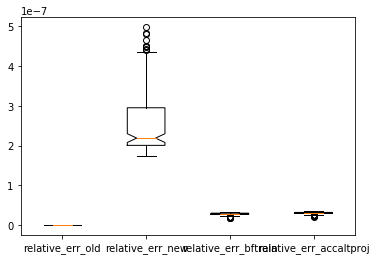

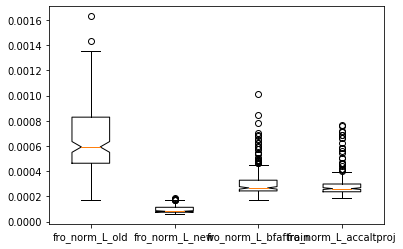

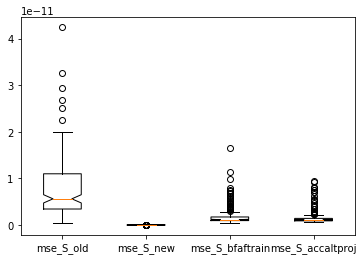

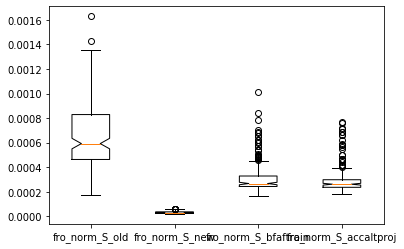

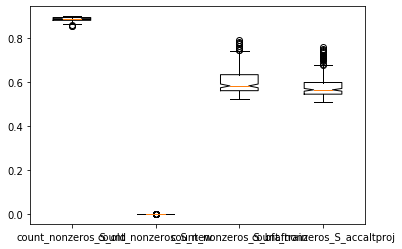

In [8]:
metrics = get_metrics(train, [x[:2] for x in train_est], out_bftrain, out_hat)
fro_norm_L_old, mse_S_old, fro_norm_S_old, count_nonzeros_S_old, relative_err_old, \
    fro_norm_L_new, mse_S_new, fro_norm_S_new, count_nonzeros_S_new, relative_err_new, \
    fro_norm_L_bftrain, mse_S_bftrain, fro_norm_S_bftrain, count_nonzeros_S_bftrain, relative_err_bftrain \
        = metrics.values()
fro_norm_L_accaltproj, mse_S_accaltproj, fro_norm_S_accaltproj, count_nonzeros_S_accaltproj, relative_err_accaltproj \
    = list(get_metrics(train, out_accaltproj, out_bftrain, out_hat).values())[:5]

fig, ax = plt.subplots()
ax.boxplot([relative_err_old, relative_err_new, relative_err_bftrain, relative_err_accaltproj], notch = True)
ax.set_xticklabels(["relative_err_old", "relative_err_new", "relative_err_bftrain", "relative_err_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([fro_norm_L_old, fro_norm_L_new, fro_norm_L_bftrain, fro_norm_L_accaltproj], notch = True)
ax.set_xticklabels(["fro_norm_L_old", "fro_norm_L_new", "fro_norm_L_bfaftrain", "fro_norm_L_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([mse_S_old, mse_S_new, mse_S_bftrain, mse_S_accaltproj], notch = True)
ax.set_xticklabels(["mse_S_old", "mse_S_new", "mse_S_bfaftrain", "mse_S_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([fro_norm_S_old, fro_norm_S_new, fro_norm_S_bftrain, fro_norm_S_accaltproj], notch = True)
ax.set_xticklabels(["fro_norm_S_old", "fro_norm_S_new", "fro_norm_S_bfaftrain", "fro_norm_S_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([count_nonzeros_S_old, count_nonzeros_S_new, count_nonzeros_S_bftrain, count_nonzeros_S_accaltproj], notch = True)
ax.set_xticklabels(["count_nonzeros_S_old", "count_nonzeros_S_new", "count_nonzeros_S_bfaftrain", "count_nonzeros_S_accaltproj"])
plt.show()

In [9]:
print("P-values from test of mean with H1: _new < _old")
print("relative_err_new, relative_err_old: ", stats.ttest_rel(relative_err_new, relative_err_old, alternative='less').pvalue)
print("fro_norm_L_new, fro_norm_L_old: ", stats.ttest_rel(fro_norm_L_new, fro_norm_L_old, alternative='less').pvalue)
print("mse_S_new, mse_S_old: ", stats.ttest_rel(mse_S_new, mse_S_old, alternative='less').pvalue)
print("fro_norm_S_new, fro_norm_S_old: ", stats.ttest_rel(fro_norm_S_new, fro_norm_S_old, alternative='less').pvalue)
print("count_nonzeros_S_new, count_nonzeros_S_old: ", stats.ttest_rel(count_nonzeros_S_new, count_nonzeros_S_old, alternative='less').pvalue)
print()
print("P-values from test of mean with H1: _new < _accaltproj")
print("relative_err_new, relative_err_accaltproj: ", stats.ttest_rel(relative_err_new, relative_err_accaltproj, alternative='less').pvalue)
print("fro_norm_L_new, fro_norm_L_accaltproj: ", stats.ttest_rel(fro_norm_L_new, fro_norm_L_accaltproj, alternative='less').pvalue)
print("mse_S_new, mse_S_accaltproj: ", stats.ttest_rel(mse_S_new, mse_S_accaltproj, alternative='less').pvalue)
print("fro_norm_S_new, fro_norm_S_accaltproj: ", stats.ttest_rel(fro_norm_S_new, fro_norm_S_accaltproj, alternative='less').pvalue)
print("count_nonzeros_S_new, count_nonzeros_S_accaltproj: ", stats.ttest_rel(count_nonzeros_S_new, count_nonzeros_S_accaltproj, alternative='less').pvalue)
print()
print("relative_err_new, relative_err_bftrain: ", stats.ttest_rel(relative_err_new, relative_err_bftrain, alternative='less').pvalue)
print("fro_norm_L_new, fro_norm_L_bftrain: ", stats.ttest_rel(fro_norm_L_new, fro_norm_L_bftrain, alternative='less').pvalue)
print("mse_S_new, mse_S_bftrain: ", stats.ttest_rel(mse_S_new, mse_S_bftrain, alternative='less').pvalue)
print("fro_norm_S_new, fro_norm_S_bftrain: ", stats.ttest_rel(fro_norm_S_new, fro_norm_S_bftrain, alternative='less').pvalue)
print("count_nonzeros_S_new, count_nonzeros_S_bftrain: ", stats.ttest_rel(count_nonzeros_S_new, count_nonzeros_S_bftrain, alternative='less').pvalue)

# print("*Note: values are log-transformed before deriving p-values")
# print()
# print("relative_err_new, relative_err_old: ", stats.ttest_rel(np.log(relative_err_new), np.log(relative_err_old), alternative='less').pvalue)
# print("fro_norm_L_new, fro_norm_L_old: ", stats.ttest_rel(np.log(fro_norm_L_new), np.log(fro_norm_L_old), alternative='less').pvalue)
# print("mse_S_new, mse_S_old: ", stats.ttest_rel(np.log(mse_S_new), np.log(mse_S_old), alternative='less').pvalue)
# print("fro_norm_S_new, fro_norm_S_old: ", stats.ttest_rel(np.log(fro_norm_S_new), np.log(fro_norm_S_old), alternative='less').pvalue)
# print("count_nonzeros_S_new, count_nonzeros_S_old: ", stats.ttest_rel(np.log(count_nonzeros_S_new), np.log(count_nonzeros_S_old), alternative='less').pvalue)
# print()
# print("P-values from test of mean with H1: _new < _accaltproj")
# print("relative_err_new, relative_err_accaltproj: ", stats.ttest_rel(np.log(relative_err_new), np.log(relative_err_accaltproj), alternative='less').pvalue)
# print("fro_norm_L_new, fro_norm_L_accaltproj: ", stats.ttest_rel(np.log(fro_norm_L_new), np.log(fro_norm_L_accaltproj), alternative='less').pvalue)
# print("mse_S_new, mse_S_accaltproj: ", stats.ttest_rel(np.log(mse_S_new), np.log(mse_S_accaltproj), alternative='less').pvalue)
# print("fro_norm_S_new, fro_norm_S_accaltproj: ", stats.ttest_rel(np.log(fro_norm_S_new), np.log(fro_norm_S_accaltproj), alternative='less').pvalue)
# print("count_nonzeros_S_new, count_nonzeros_S_accaltproj: ", stats.ttest_rel(np.log(count_nonzeros_S_new), np.log(count_nonzeros_S_accaltproj), alternative='less').pvalue)
# print()
# print("relative_err_new, relative_err_bftrain: ", stats.ttest_rel(np.log(relative_err_new), np.log(relative_err_bftrain), alternative='less').pvalue)
# print("fro_norm_L_new, fro_norm_L_bftrain: ", stats.ttest_rel(np.log(fro_norm_L_new), np.log(fro_norm_L_bftrain), alternative='less').pvalue)
# print("mse_S_new, mse_S_bftrain: ", stats.ttest_rel(np.log(mse_S_new), np.log(mse_S_bftrain), alternative='less').pvalue)
# print("fro_norm_S_new, fro_norm_S_bftrain: ", stats.ttest_rel(np.log(fro_norm_S_new), np.log(fro_norm_S_bftrain), alternative='less').pvalue)
# print("count_nonzeros_S_new, count_nonzeros_S_bftrain: ", stats.ttest_rel(np.log(count_nonzeros_S_new), np.log(count_nonzeros_S_bftrain), alternative='less').pvalue)

P-values from test of mean with H1: _new < _old
relative_err_new, relative_err_old:  1.0
fro_norm_L_new, fro_norm_L_old:  7.275256857157337e-67
mse_S_new, mse_S_old:  5.738798694878335e-37
fro_norm_S_new, fro_norm_S_old:  3.419587940999554e-74
count_nonzeros_S_new, count_nonzeros_S_old:  0.0

P-values from test of mean with H1: _new < _accaltproj
relative_err_new, relative_err_accaltproj:  1.0
fro_norm_L_new, fro_norm_L_accaltproj:  2.4207854694608936e-55
mse_S_new, mse_S_accaltproj:  9.357887286758739e-29
fro_norm_S_new, fro_norm_S_accaltproj:  6.845783175248412e-73
count_nonzeros_S_new, count_nonzeros_S_accaltproj:  2.2582490858899192e-181

relative_err_new, relative_err_bftrain:  1.0
fro_norm_L_new, fro_norm_L_bftrain:  1.1091982273263682e-53
mse_S_new, mse_S_bftrain:  4.5894841220501e-26
fro_norm_S_new, fro_norm_S_bftrain:  7.938618183678935e-69
count_nonzeros_S_new, count_nonzeros_S_bftrain:  1.0486402379967555e-179


/var/folders/st/_q3p7lz50mncs1x1m22w92gc0000gn/T/ipykernel_9004/2174885101.py:1: RuntimeWarning: divide by zero encountered in true_divide
  relative_err = np.array([relative_err_new[i]/ relative_err_old[i] for i in range(len(relative_err_new))])
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/lib/function_base.py:4486: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


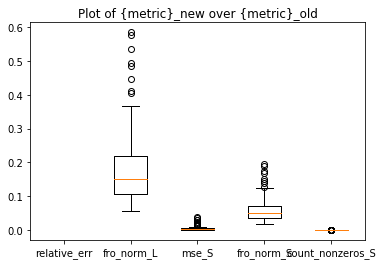

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/lib/function_base.py:4486: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


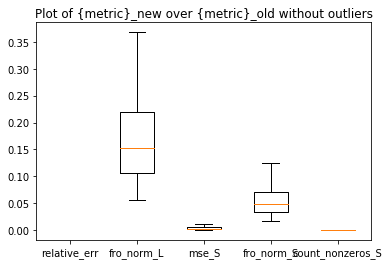

relative_err: 0/180 outliers
fro_norm_L: 8/180 outliers
mse_S: 14/180 outliers
fro_norm_S: 8/180 outliers
count_nonzeros_S: 180/180 outliers


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/lib/function_base.py:4486: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


In [10]:
relative_err = np.array([relative_err_new[i]/ relative_err_old[i] for i in range(len(relative_err_new))])
fro_norm_L = np.array([fro_norm_L_new[i]/ fro_norm_L_old[i] for i in range(len(fro_norm_L_new))])
mse_S = np.array([mse_S_new[i]/ mse_S_old[i] for i in range(len(mse_S_new))])
fro_norm_S = np.array([fro_norm_S_new[i]/ fro_norm_S_old[i] for i in range(len(fro_norm_S_new))])
count_nonzeros_S = np.array([count_nonzeros_S_new[i]/ count_nonzeros_S_old[i] for i in range(len(count_nonzeros_S_new))])
d = {"relative_err": relative_err \
    , "fro_norm_L": fro_norm_L \
    , "mse_S": mse_S \
    , "fro_norm_S": fro_norm_S \
    , "count_nonzeros_S": count_nonzeros_S
    }

fig, ax = plt.subplots()
ax.boxplot(d.values())
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_old")
plt.show()

fig, ax = plt.subplots()
ax.boxplot(d.values(), showfliers=False)
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_old without outliers")
plt.show()

for key, val in d.items():
    print(f"{key}: {count_outliers(d[key])}/{len(relative_err)} outliers")

In [11]:
print("P-values from test of mean with H1: _new/_old < 1")
# print("*Note: values are log-transformed before deriving p-values \n")
for key, val in d.items():
    print(f'{key}: ', stats.ttest_1samp(val, 1, alternative='less').pvalue)

P-values from test of mean with H1: _new/_old < 1
relative_err:  nan
fro_norm_L:  2.4817974458118724e-167
mse_S:  0.0
fro_norm_S:  2.3785963106358053e-263
count_nonzeros_S:  0.0


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1182: RuntimeWarning: invalid value encountered in subtract
  a_zero_mean = a - mean


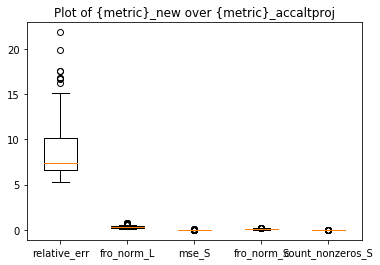

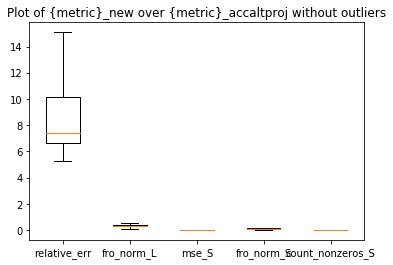

relative_err: 8/180 outliers
fro_norm_L: 14/180 outliers
mse_S: 20/180 outliers
fro_norm_S: 16/180 outliers
count_nonzeros_S: 180/180 outliers


In [12]:
relative_err = np.array([relative_err_new[i]/ relative_err_accaltproj[i] for i in range(len(relative_err_new))])
fro_norm_L = np.array([fro_norm_L_new[i]/ fro_norm_L_accaltproj[i] for i in range(len(fro_norm_L_new))])
mse_S = np.array([mse_S_new[i]/ mse_S_accaltproj[i] for i in range(len(mse_S_new))])
fro_norm_S = np.array([fro_norm_S_new[i]/ fro_norm_S_accaltproj[i] for i in range(len(fro_norm_S_new))])
count_nonzeros_S = np.array([count_nonzeros_S_new[i]/ count_nonzeros_S_accaltproj[i] for i in range(len(count_nonzeros_S_new))])
d = {"relative_err": relative_err \
    , "fro_norm_L": fro_norm_L \
    , "mse_S": mse_S \
    , "fro_norm_S": fro_norm_S \
    , "count_nonzeros_S": count_nonzeros_S
    }

fig, ax = plt.subplots()
ax.boxplot(d.values())
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_accaltproj")
plt.show()

fig, ax = plt.subplots()
ax.boxplot(d.values(), showfliers=False)
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_accaltproj without outliers")
plt.show()

for key, val in d.items():
    print(f"{key}: {count_outliers(d[key])}/{len(relative_err)} outliers")

In [13]:
print("P-values from test of mean with H1: _new/_accaltproj < 1")
#print("*Note: values are log-transformed before deriving p-values \n")
for key, val in d.items():
    print(f'{key}: ', stats.ttest_1samp(val, 1, alternative='less').pvalue)

P-values from test of mean with H1: _new/_accaltproj < 1
relative_err:  1.0
fro_norm_L:  3.251088092204569e-126
mse_S:  0.0
fro_norm_S:  8.309654011576132e-235
count_nonzeros_S:  0.0


#### Evaluating unrolled network on test dataset

In [14]:
out_bftrain_ontest, out_hat_ontest = get_net_outputs(net, LearnedAAP(max_iter), r, test)
out_accaltproj_ontest = []
out_ircur_ontest = []
for (L_true, S_true, M_true) in test:
    loss0, L0, S0 = AccAltProj(M_true, r, 1e-06, torch.tensor(0.7), max_iter)
    out_accaltproj_ontest.append((L0, S0))
    loss0, L0, S0 = IRCUR(M_true, r, 1e-06, torch.tensor(0.7), 3, max_iter*2)
    out_ircur_ontest.append((L0, S0))

/Users/elitanzc/Github/FYP/helper.py:254: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mat1 = (torch.tensor(mat1) == 0)
/Users/elitanzc/Github/FYP/helper.py:255: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mat2 = (torch.tensor(mat2) == 0)


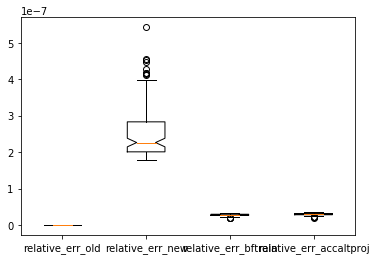

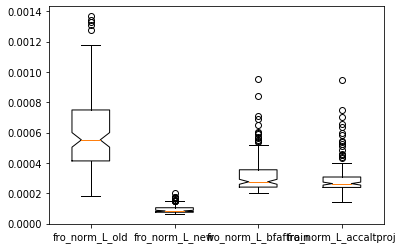

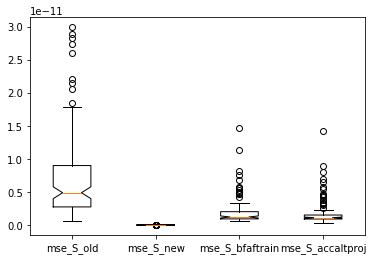

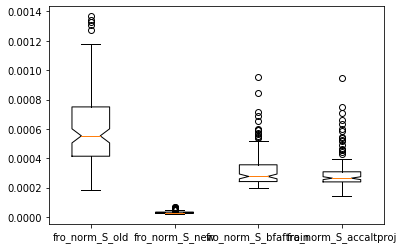

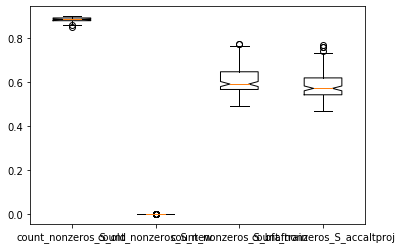

In [15]:
metrics = get_metrics(test, out_ircur_ontest, out_bftrain_ontest, out_hat_ontest)
fro_norm_L_old, mse_S_old, fro_norm_S_old, count_nonzeros_S_old, relative_err_old, \
    fro_norm_L_new, mse_S_new, fro_norm_S_new, count_nonzeros_S_new, relative_err_new, \
    fro_norm_L_bftrain, mse_S_bftrain, fro_norm_S_bftrain, count_nonzeros_S_bftrain, relative_err_bftrain \
        = metrics.values()
fro_norm_L_accaltproj, mse_S_accaltproj, fro_norm_S_accaltproj, count_nonzeros_S_accaltproj, relative_err_accaltproj \
    = list(get_metrics(test, out_accaltproj_ontest, out_bftrain_ontest, out_hat_ontest).values())[:5]

fig, ax = plt.subplots()
ax.boxplot([relative_err_old, relative_err_new, relative_err_bftrain, relative_err_accaltproj], notch = True)
ax.set_xticklabels(["relative_err_old", "relative_err_new", "relative_err_bftrain", "relative_err_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([fro_norm_L_old, fro_norm_L_new, fro_norm_L_bftrain, fro_norm_L_accaltproj], notch = True)
ax.set_xticklabels(["fro_norm_L_old", "fro_norm_L_new", "fro_norm_L_bfaftrain", "fro_norm_L_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([mse_S_old, mse_S_new, mse_S_bftrain, mse_S_accaltproj], notch = True)
ax.set_xticklabels(["mse_S_old", "mse_S_new", "mse_S_bfaftrain", "mse_S_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([fro_norm_S_old, fro_norm_S_new, fro_norm_S_bftrain, fro_norm_S_accaltproj], notch = True)
ax.set_xticklabels(["fro_norm_S_old", "fro_norm_S_new", "fro_norm_S_bfaftrain", "fro_norm_S_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([count_nonzeros_S_old, count_nonzeros_S_new, count_nonzeros_S_bftrain, count_nonzeros_S_accaltproj], notch = True)
ax.set_xticklabels(["count_nonzeros_S_old", "count_nonzeros_S_new", "count_nonzeros_S_bfaftrain", "count_nonzeros_S_accaltproj"])
plt.show()

In [16]:
print("P-values from test of mean with H1: _new < _old")
print("relative_err_new, relative_err_old: ", stats.ttest_rel(relative_err_new, relative_err_old, alternative='less').pvalue)
print("fro_norm_L_new, fro_norm_L_old: ", stats.ttest_rel(fro_norm_L_new, fro_norm_L_old, alternative='less').pvalue)
print("mse_S_new, mse_S_old: ", stats.ttest_rel(mse_S_new, mse_S_old, alternative='less').pvalue)
print("fro_norm_S_new, fro_norm_S_old: ", stats.ttest_rel(fro_norm_S_new, fro_norm_S_old, alternative='less').pvalue)
print("count_nonzeros_S_new, count_nonzeros_S_old: ", stats.ttest_rel(count_nonzeros_S_new, count_nonzeros_S_old, alternative='less').pvalue)
print()
print("P-values from test of mean with H1: _new < _accaltproj")
print("relative_err_new, relative_err_accaltproj: ", stats.ttest_rel(relative_err_new, relative_err_accaltproj, alternative='less').pvalue)
print("fro_norm_L_new, fro_norm_L_accaltproj: ", stats.ttest_rel(fro_norm_L_new, fro_norm_L_accaltproj, alternative='less').pvalue)
print("mse_S_new, mse_S_accaltproj: ", stats.ttest_rel(mse_S_new, mse_S_accaltproj, alternative='less').pvalue)
print("fro_norm_S_new, fro_norm_S_accaltproj: ", stats.ttest_rel(fro_norm_S_new, fro_norm_S_accaltproj, alternative='less').pvalue)
print("count_nonzeros_S_new, count_nonzeros_S_accaltproj: ", stats.ttest_rel(count_nonzeros_S_new, count_nonzeros_S_accaltproj, alternative='less').pvalue)
print()
print("relative_err_new, relative_err_bftrain: ", stats.ttest_rel(relative_err_new, relative_err_bftrain, alternative='less').pvalue)
print("fro_norm_L_new, fro_norm_L_bftrain: ", stats.ttest_rel(fro_norm_L_new, fro_norm_L_bftrain, alternative='less').pvalue)
print("mse_S_new, mse_S_bftrain: ", stats.ttest_rel(mse_S_new, mse_S_bftrain, alternative='less').pvalue)
print("fro_norm_S_new, fro_norm_S_bftrain: ", stats.ttest_rel(fro_norm_S_new, fro_norm_S_bftrain, alternative='less').pvalue)
print("count_nonzeros_S_new, count_nonzeros_S_bftrain: ", stats.ttest_rel(count_nonzeros_S_new, count_nonzeros_S_bftrain, alternative='less').pvalue)

# print("*Note: values are log-transformed before deriving p-values")
# print()
# print("relative_err_new, relative_err_old: ", stats.ttest_rel(np.log(relative_err_new), np.log(relative_err_old), alternative='less').pvalue)
# print("fro_norm_L_new, fro_norm_L_old: ", stats.ttest_rel(np.log(fro_norm_L_new), np.log(fro_norm_L_old), alternative='less').pvalue)
# print("mse_S_new, mse_S_old: ", stats.ttest_rel(np.log(mse_S_new), np.log(mse_S_old), alternative='less').pvalue)
# print("fro_norm_S_new, fro_norm_S_old: ", stats.ttest_rel(np.log(fro_norm_S_new), np.log(fro_norm_S_old), alternative='less').pvalue)
# print("count_nonzeros_S_new, count_nonzeros_S_old: ", stats.ttest_rel(np.log(count_nonzeros_S_new), np.log(count_nonzeros_S_old), alternative='less').pvalue)
# print()
# print("P-values from test of mean with H1: _new < _accaltproj")
# print("relative_err_new, relative_err_accaltproj: ", stats.ttest_rel(np.log(relative_err_new), np.log(relative_err_accaltproj), alternative='less').pvalue)
# print("fro_norm_L_new, fro_norm_L_accaltproj: ", stats.ttest_rel(np.log(fro_norm_L_new), np.log(fro_norm_L_accaltproj), alternative='less').pvalue)
# print("mse_S_new, mse_S_accaltproj: ", stats.ttest_rel(np.log(mse_S_new), np.log(mse_S_accaltproj), alternative='less').pvalue)
# print("fro_norm_S_new, fro_norm_S_accaltproj: ", stats.ttest_rel(np.log(fro_norm_S_new), np.log(fro_norm_S_accaltproj), alternative='less').pvalue)
# print("count_nonzeros_S_new, count_nonzeros_S_accaltproj: ", stats.ttest_rel(np.log(count_nonzeros_S_new), np.log(count_nonzeros_S_accaltproj), alternative='less').pvalue)
# print()
# print("relative_err_new, relative_err_bftrain: ", stats.ttest_rel(np.log(relative_err_new), np.log(relative_err_bftrain), alternative='less').pvalue)
# print("fro_norm_L_new, fro_norm_L_bftrain: ", stats.ttest_rel(np.log(fro_norm_L_new), np.log(fro_norm_L_bftrain), alternative='less').pvalue)
# print("mse_S_new, mse_S_bftrain: ", stats.ttest_rel(np.log(mse_S_new), np.log(mse_S_bftrain), alternative='less').pvalue)
# print("fro_norm_S_new, fro_norm_S_bftrain: ", stats.ttest_rel(np.log(fro_norm_S_new), np.log(fro_norm_S_bftrain), alternative='less').pvalue)
# print("count_nonzeros_S_new, count_nonzeros_S_bftrain: ", stats.ttest_rel(np.log(count_nonzeros_S_new), np.log(count_nonzeros_S_bftrain), alternative='less').pvalue)

P-values from test of mean with H1: _new < _old
relative_err_new, relative_err_old:  1.0
fro_norm_L_new, fro_norm_L_old:  2.8362193725695804e-42
mse_S_new, mse_S_old:  1.1608324893440062e-22
fro_norm_S_new, fro_norm_S_old:  9.278552343084226e-47
count_nonzeros_S_new, count_nonzeros_S_old:  5.973019081928942e-237

P-values from test of mean with H1: _new < _accaltproj
relative_err_new, relative_err_accaltproj:  1.0
fro_norm_L_new, fro_norm_L_accaltproj:  2.647376756347695e-37
mse_S_new, mse_S_accaltproj:  5.396389160582222e-18
fro_norm_S_new, fro_norm_S_accaltproj:  3.4144779754412154e-48
count_nonzeros_S_new, count_nonzeros_S_accaltproj:  1.0131649387791091e-119

relative_err_new, relative_err_bftrain:  1.0
fro_norm_L_new, fro_norm_L_bftrain:  9.961768354084681e-37
mse_S_new, mse_S_bftrain:  9.634343606168626e-19
fro_norm_S_new, fro_norm_S_bftrain:  1.9007927564899463e-47
count_nonzeros_S_new, count_nonzeros_S_bftrain:  7.0997970569130595e-121


/var/folders/st/_q3p7lz50mncs1x1m22w92gc0000gn/T/ipykernel_9004/3102520907.py:1: RuntimeWarning: divide by zero encountered in true_divide
  relative_err = np.array([relative_err_new[i]/ relative_err_old[i] for i in range(len(relative_err_new))])
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/lib/function_base.py:4486: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


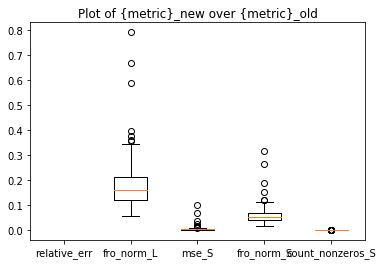

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/lib/function_base.py:4486: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


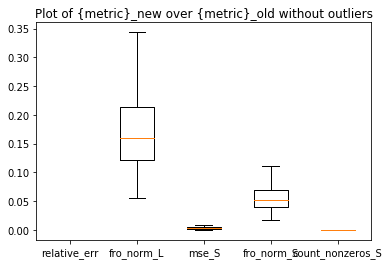

relative_err: 0/120 outliers
fro_norm_L: 7/120 outliers
mse_S: 14/120 outliers
fro_norm_S: 6/120 outliers
count_nonzeros_S: 120/120 outliers


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/lib/function_base.py:4486: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


In [17]:
relative_err = np.array([relative_err_new[i]/ relative_err_old[i] for i in range(len(relative_err_new))])
fro_norm_L = np.array([fro_norm_L_new[i]/ fro_norm_L_old[i] for i in range(len(fro_norm_L_new))])
mse_S = np.array([mse_S_new[i]/ mse_S_old[i] for i in range(len(mse_S_new))])
fro_norm_S = np.array([fro_norm_S_new[i]/ fro_norm_S_old[i] for i in range(len(fro_norm_S_new))])
count_nonzeros_S = np.array([count_nonzeros_S_new[i]/ count_nonzeros_S_old[i] for i in range(len(count_nonzeros_S_new))])
d = {"relative_err": relative_err, \
     "fro_norm_L": fro_norm_L \
    , "mse_S": mse_S \
    , "fro_norm_S": fro_norm_S \
    , "count_nonzeros_S": count_nonzeros_S
    }

fig, ax = plt.subplots()
ax.boxplot(d.values())
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_old")
plt.show()

fig, ax = plt.subplots()
ax.boxplot(d.values(), showfliers=False)
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_old without outliers")
plt.show()

for key, val in d.items():
    print(f"{key}: {count_outliers(d[key])}/{len(relative_err)} outliers")

In [18]:
print("P-values from test of mean with H1: _new/_old < 1")
# print("*Note: values are log-transformed before deriving p-values \n")
for key, val in d.items():
    print(f'{key}: ', stats.ttest_1samp(val, 1, alternative='less').pvalue)

P-values from test of mean with H1: _new/_old < 1
relative_err:  nan
fro_norm_L:  1.356564923401601e-106
mse_S:  1.0831126335645e-232
fro_norm_S:  1.8338504934515564e-164
count_nonzeros_S:  0.0


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1182: RuntimeWarning: invalid value encountered in subtract
  a_zero_mean = a - mean


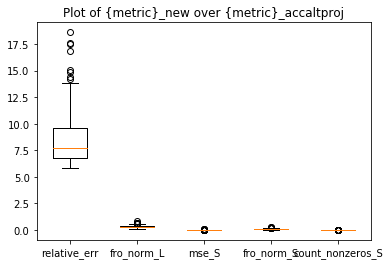

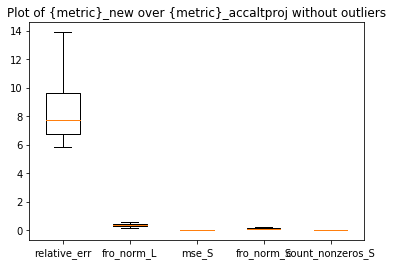

relative_err: 8/120 outliers
fro_norm_L: 6/120 outliers
mse_S: 14/120 outliers
fro_norm_S: 8/120 outliers
count_nonzeros_S: 120/120 outliers


In [19]:
relative_err = np.array([relative_err_new[i]/ relative_err_accaltproj[i] for i in range(len(relative_err_new))])
fro_norm_L = np.array([fro_norm_L_new[i]/ fro_norm_L_accaltproj[i] for i in range(len(fro_norm_L_new))])
mse_S = np.array([mse_S_new[i]/ mse_S_accaltproj[i] for i in range(len(mse_S_new))])
fro_norm_S = np.array([fro_norm_S_new[i]/ fro_norm_S_accaltproj[i] for i in range(len(fro_norm_S_new))])
count_nonzeros_S = np.array([count_nonzeros_S_new[i]/ count_nonzeros_S_accaltproj[i] for i in range(len(count_nonzeros_S_new))])
d = {"relative_err": relative_err, \
     "fro_norm_L": fro_norm_L \
    , "mse_S": mse_S \
    , "fro_norm_S": fro_norm_S \
    , "count_nonzeros_S": count_nonzeros_S
    }

fig, ax = plt.subplots()
ax.boxplot(d.values())
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_accaltproj")
plt.show()

fig, ax = plt.subplots()
ax.boxplot(d.values(), showfliers=False)
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_accaltproj without outliers")
plt.show()

for key, val in d.items():
    print(f"{key}: {count_outliers(d[key])}/{len(relative_err)} outliers")

In [20]:
print("P-values from test of mean with H1: _new/_accaltproj < 1")
#print("*Note: values are log-transformed before deriving p-values \n")
for key, val in d.items():
    print(f'{key}: ', stats.ttest_1samp(val, 1, alternative='less').pvalue)

P-values from test of mean with H1: _new/_accaltproj < 1
relative_err:  1.0
fro_norm_L:  6.583377918015419e-87
mse_S:  5.497631229151881e-224
fro_norm_S:  1.3944778211398162e-155
count_nonzeros_S:  0.0


In [21]:
print(np.median(count_nonzeros_S_new), np.mean(count_nonzeros_S_new))
print(np.median(count_nonzeros_S_accaltproj), np.mean(count_nonzeros_S_accaltproj))

0.0 3.3333336e-06
0.571512 0.5881582


### Scenario 2:
**alpha = 0.3** (higher sparsity), **c = 1**, r = 2, dimension = 250x250

gamma=7.433e-01,; beta=5.649e-02

In [22]:
## ======================== 0. set constants ========================
#d1 = 250                   # num. of rows
#d2 = 250                   # num. of columns
#max_iter = 100              # num. of layers trained
alpha_true = 0.3
c_true = 1
#r = 2
#dataset_size = 300

## ======================== 1. generate data ========================
train2, test2 =  generate_train_test(dataset_size, r, d1, d2, alpha_true, c_true)

train dataset size: 180
test dataset size: 120


#### Training

In [23]:
## ======================== 2. estimations by classical ========================
train_est2 = []
for i, (L_true, S_true, M_true) in enumerate(train2):
    loss, L0, S0 = IRCUR(M_true, r, 1e-06, torch.tensor(0.7), 3, max_iter*2)
    train_est2.append((L0, S0, M_true))

In [73]:
## ======================== 3. train unrolled network with estimated data ========================
net2, params_bftrain2, params_aftrain2, l0_norm_of_S_Shat2 = train_nn(LearnedAAP(max_iter), r \
                                                                    , lr=2e-03, weight_decay=0 \
                                                                    , nepochs=5, dataset=train_est2)

[Parameter containing:
tensor(7.000e-01, requires_grad=True), Parameter containing:
tensor(3.001e-02, requires_grad=True)]
tensor(-1.416e-10) tensor(-6.008e-11)
Epoch 1/5 at cost=3.554809571704176e-11
[Parameter containing:
tensor(7.001e-01, requires_grad=True), Parameter containing:
tensor(3.004e-02, requires_grad=True)]
tensor(-3.859e-10) tensor(-2.032e-10)
Epoch 1/5 at cost=1.1148600098653816e-10
[Parameter containing:
tensor(7.002e-01, requires_grad=True), Parameter containing:
tensor(3.009e-02, requires_grad=True)]
tensor(-8.092e-10) tensor(-4.247e-10)
Epoch 1/5 at cost=1.0340142631015681e-10
[Parameter containing:
tensor(7.003e-01, requires_grad=True), Parameter containing:
tensor(3.013e-02, requires_grad=True)]
tensor(-4.014e-10) tensor(-2.139e-10)
Epoch 1/5 at cost=1.706763202991013e-11
[Parameter containing:
tensor(7.004e-01, requires_grad=True), Parameter containing:
tensor(3.024e-02, requires_grad=True)]
tensor(-3.086e-09) tensor(-1.562e-09)
Epoch 1/5 at cost=2.6003851849587

#### Evaluating unrolled network on train dataset

In [74]:
out_bftrain2, out_hat2 = get_net_outputs(net2, LearnedAAP(max_iter), r, train2)
out_accaltproj2 = []
for i, (L_true, S_true, M_true) in enumerate(train2):
    loss, L0, S0 = AccAltProj(M_true, r, 1e-06, torch.tensor(0.7), max_iter)
    out_accaltproj2.append((L0, S0))

/Users/elitanzc/Github/FYP/helper.py:254: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mat1 = (torch.tensor(mat1) == 0)
/Users/elitanzc/Github/FYP/helper.py:255: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mat2 = (torch.tensor(mat2) == 0)


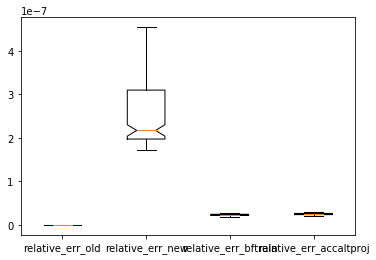

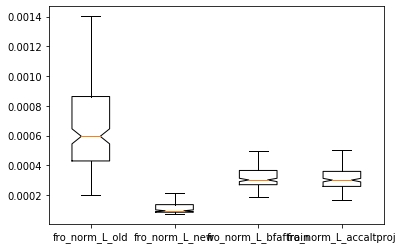

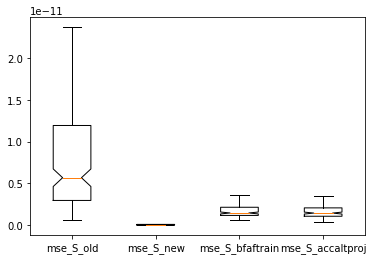

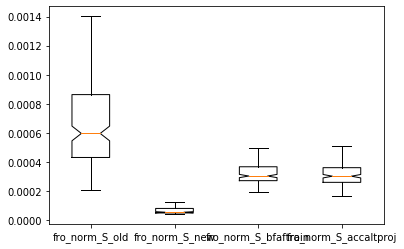

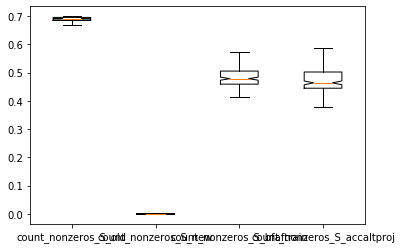

In [75]:
metrics = get_metrics(train2, [x[:2] for x in train_est2], out_bftrain2, out_hat2)
fro_norm_L_old, mse_S_old, fro_norm_S_old, count_nonzeros_S_old, relative_err_old, \
    fro_norm_L_new, mse_S_new, fro_norm_S_new, count_nonzeros_S_new, relative_err_new, \
    fro_norm_L_bftrain, mse_S_bftrain, fro_norm_S_bftrain, count_nonzeros_S_bftrain, relative_err_bftrain \
        = metrics.values()
fro_norm_L_accaltproj, mse_S_accaltproj, fro_norm_S_accaltproj, count_nonzeros_S_accaltproj, relative_err_accaltproj \
    = list(get_metrics(train2, out_accaltproj2, out_bftrain2, out_hat2).values())[:5]

fig, ax = plt.subplots()
ax.boxplot([relative_err_old, relative_err_new, relative_err_bftrain, relative_err_accaltproj], notch = True, showfliers=False)
ax.set_xticklabels(["relative_err_old", "relative_err_new", "relative_err_bftrain", "relative_err_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([fro_norm_L_old, fro_norm_L_new, fro_norm_L_bftrain, fro_norm_L_accaltproj], notch = True, showfliers=False)
ax.set_xticklabels(["fro_norm_L_old", "fro_norm_L_new", "fro_norm_L_bfaftrain", "fro_norm_L_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([mse_S_old, mse_S_new, mse_S_bftrain, mse_S_accaltproj], notch = True, showfliers=False)
ax.set_xticklabels(["mse_S_old", "mse_S_new", "mse_S_bfaftrain", "mse_S_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([fro_norm_S_old, fro_norm_S_new, fro_norm_S_bftrain, fro_norm_S_accaltproj], notch = True, showfliers=False)
ax.set_xticklabels(["fro_norm_S_old", "fro_norm_S_new", "fro_norm_S_bfaftrain", "fro_norm_S_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([count_nonzeros_S_old, count_nonzeros_S_new, count_nonzeros_S_bftrain, count_nonzeros_S_accaltproj], notch = True, showfliers=False)
ax.set_xticklabels(["count_nonzeros_S_old", "count_nonzeros_S_new", "count_nonzeros_S_bfaftrain", "count_nonzeros_S_accaltproj"])
plt.show()

In [76]:
print("P-values from test of mean with H1: _new < _old")
print("relative_err_new, relative_err_old: ", stats.ttest_rel(relative_err_new, relative_err_old, alternative='less').pvalue)
print("fro_norm_L_new, fro_norm_L_old: ", stats.ttest_rel(fro_norm_L_new, fro_norm_L_old, alternative='less').pvalue)
print("mse_S_new, mse_S_old: ", stats.ttest_rel(mse_S_new, mse_S_old, alternative='less').pvalue)
print("fro_norm_S_new, fro_norm_S_old: ", stats.ttest_rel(fro_norm_S_new, fro_norm_S_old, alternative='less').pvalue)
print("count_nonzeros_S_new, count_nonzeros_S_old: ", stats.ttest_rel(count_nonzeros_S_new, count_nonzeros_S_old, alternative='less').pvalue)
print()
print("P-values from test of mean with H1: _new < _accaltproj")
print("relative_err_new, relative_err_accaltproj: ", stats.ttest_rel(relative_err_new, relative_err_accaltproj, alternative='less').pvalue)
print("fro_norm_L_new, fro_norm_L_accaltproj: ", stats.ttest_rel(fro_norm_L_new, fro_norm_L_accaltproj, alternative='less').pvalue)
print("mse_S_new, mse_S_accaltproj: ", stats.ttest_rel(mse_S_new, mse_S_accaltproj, alternative='less').pvalue)
print("fro_norm_S_new, fro_norm_S_accaltproj: ", stats.ttest_rel(fro_norm_S_new, fro_norm_S_accaltproj, alternative='less').pvalue)
print("count_nonzeros_S_new, count_nonzeros_S_accaltproj: ", stats.ttest_rel(count_nonzeros_S_new, count_nonzeros_S_accaltproj, alternative='less').pvalue)
print()
print("relative_err_new, relative_err_bftrain: ", stats.ttest_rel(relative_err_new, relative_err_bftrain, alternative='less').pvalue)
print("fro_norm_L_new, fro_norm_L_bftrain: ", stats.ttest_rel(fro_norm_L_new, fro_norm_L_bftrain, alternative='less').pvalue)
print("mse_S_new, mse_S_bftrain: ", stats.ttest_rel(mse_S_new, mse_S_bftrain, alternative='less').pvalue)
print("fro_norm_S_new, fro_norm_S_bftrain: ", stats.ttest_rel(fro_norm_S_new, fro_norm_S_bftrain, alternative='less').pvalue)
print("count_nonzeros_S_new, count_nonzeros_S_bftrain: ", stats.ttest_rel(count_nonzeros_S_new, count_nonzeros_S_bftrain, alternative='less').pvalue)

# print("*Note: values are log-transformed before deriving p-values")
# print()
# print("relative_err_new, relative_err_old: ", stats.ttest_rel(np.log(relative_err_new), np.log(relative_err_old), alternative='less').pvalue)
# print("fro_norm_L_new, fro_norm_L_old: ", stats.ttest_rel(np.log(fro_norm_L_new), np.log(fro_norm_L_old), alternative='less').pvalue)
# print("mse_S_new, mse_S_old: ", stats.ttest_rel(np.log(mse_S_new), np.log(mse_S_old), alternative='less').pvalue)
# print("fro_norm_S_new, fro_norm_S_old: ", stats.ttest_rel(np.log(fro_norm_S_new), np.log(fro_norm_S_old), alternative='less').pvalue)
# print("count_nonzeros_S_new, count_nonzeros_S_old: ", stats.ttest_rel(np.log(count_nonzeros_S_new), np.log(count_nonzeros_S_old), alternative='less').pvalue)
# print()
# print("P-values from test of mean with H1: _new < _accaltproj")
# print("relative_err_new, relative_err_accaltproj: ", stats.ttest_rel(np.log(relative_err_new), np.log(relative_err_accaltproj), alternative='less').pvalue)
# print("fro_norm_L_new, fro_norm_L_accaltproj: ", stats.ttest_rel(np.log(fro_norm_L_new), np.log(fro_norm_L_accaltproj), alternative='less').pvalue)
# print("mse_S_new, mse_S_accaltproj: ", stats.ttest_rel(np.log(mse_S_new), np.log(mse_S_accaltproj), alternative='less').pvalue)
# print("fro_norm_S_new, fro_norm_S_accaltproj: ", stats.ttest_rel(np.log(fro_norm_S_new), np.log(fro_norm_S_accaltproj), alternative='less').pvalue)
# print("count_nonzeros_S_new, count_nonzeros_S_accaltproj: ", stats.ttest_rel(np.log(count_nonzeros_S_new), np.log(count_nonzeros_S_accaltproj), alternative='less').pvalue)
# print()
# print("relative_err_new, relative_err_bftrain: ", stats.ttest_rel(np.log(relative_err_new), np.log(relative_err_bftrain), alternative='less').pvalue)
# print("fro_norm_L_new, fro_norm_L_bftrain: ", stats.ttest_rel(np.log(fro_norm_L_new), np.log(fro_norm_L_bftrain), alternative='less').pvalue)
# print("mse_S_new, mse_S_bftrain: ", stats.ttest_rel(np.log(mse_S_new), np.log(mse_S_bftrain), alternative='less').pvalue)
# print("fro_norm_S_new, fro_norm_S_bftrain: ", stats.ttest_rel(np.log(fro_norm_S_new), np.log(fro_norm_S_bftrain), alternative='less').pvalue)
# print("count_nonzeros_S_new, count_nonzeros_S_bftrain: ", stats.ttest_rel(np.log(count_nonzeros_S_new), np.log(count_nonzeros_S_bftrain), alternative='less').pvalue)

P-values from test of mean with H1: _new < _old
relative_err_new, relative_err_old:  1.0
fro_norm_L_new, fro_norm_L_old:  0.013324669067865383
mse_S_new, mse_S_old:  0.039448770163613076
fro_norm_S_new, fro_norm_S_old:  0.013222062519068479
count_nonzeros_S_new, count_nonzeros_S_old:  0.0

P-values from test of mean with H1: _new < _accaltproj
relative_err_new, relative_err_accaltproj:  1.0
fro_norm_L_new, fro_norm_L_accaltproj:  4.032729788396018e-50
mse_S_new, mse_S_accaltproj:  2.4279901589335703e-24
fro_norm_S_new, fro_norm_S_accaltproj:  2.139146910469247e-61
count_nonzeros_S_new, count_nonzeros_S_accaltproj:  7.312152435650941e-183

relative_err_new, relative_err_bftrain:  1.0
fro_norm_L_new, fro_norm_L_bftrain:  2.985084151489382e-50
mse_S_new, mse_S_bftrain:  3.785123550243757e-26
fro_norm_S_new, fro_norm_S_bftrain:  1.3379751214432533e-61
count_nonzeros_S_new, count_nonzeros_S_bftrain:  2.8825191005621403e-189


/var/folders/st/_q3p7lz50mncs1x1m22w92gc0000gn/T/ipykernel_9004/2174885101.py:1: RuntimeWarning: divide by zero encountered in true_divide
  relative_err = np.array([relative_err_new[i]/ relative_err_old[i] for i in range(len(relative_err_new))])
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/lib/function_base.py:4486: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


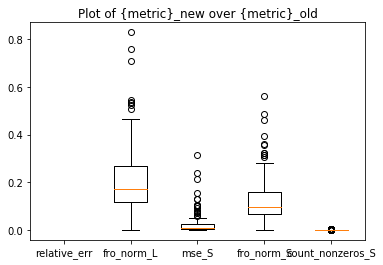

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/lib/function_base.py:4486: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


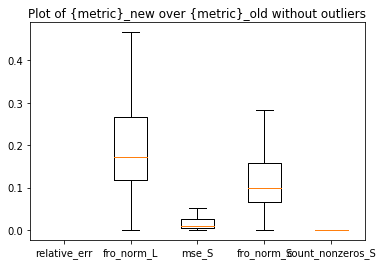

relative_err: 0/180 outliers
fro_norm_L: 8/180 outliers
mse_S: 18/180 outliers
fro_norm_S: 11/180 outliers
count_nonzeros_S: 36/180 outliers


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/lib/function_base.py:4486: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


In [77]:
relative_err = np.array([relative_err_new[i]/ relative_err_old[i] for i in range(len(relative_err_new))])
fro_norm_L = np.array([fro_norm_L_new[i]/ fro_norm_L_old[i] for i in range(len(fro_norm_L_new))])
mse_S = np.array([mse_S_new[i]/ mse_S_old[i] for i in range(len(mse_S_new))])
fro_norm_S = np.array([fro_norm_S_new[i]/ fro_norm_S_old[i] for i in range(len(fro_norm_S_new))])
count_nonzeros_S = np.array([count_nonzeros_S_new[i]/ count_nonzeros_S_old[i] for i in range(len(count_nonzeros_S_new))])
d = {"relative_err": relative_err \
    , "fro_norm_L": fro_norm_L \
    , "mse_S": mse_S \
    , "fro_norm_S": fro_norm_S \
    , "count_nonzeros_S": count_nonzeros_S
    }

fig, ax = plt.subplots()
ax.boxplot(d.values())
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_old")
plt.show()

fig, ax = plt.subplots()
ax.boxplot(d.values(), showfliers=False)
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_old without outliers")
plt.show()

for key, val in d.items():
    print(f"{key}: {count_outliers(d[key])}/{len(relative_err)} outliers")

In [78]:
print("P-values from test of mean with H1: _new/_old < 1")
# print("*Note: values are log-transformed before deriving p-values \n")
for key, val in d.items():
    print(f'{key}: ', stats.ttest_1samp(val, 1, alternative='less').pvalue)

P-values from test of mean with H1: _new/_old < 1
relative_err:  nan
fro_norm_L:  5.556772204803545e-140
mse_S:  4.419446561243867e-250
fro_norm_S:  5.347763318908394e-179
count_nonzeros_S:  0.0


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1182: RuntimeWarning: invalid value encountered in subtract
  a_zero_mean = a - mean


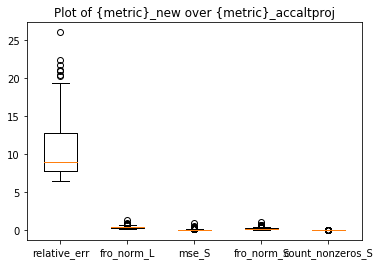

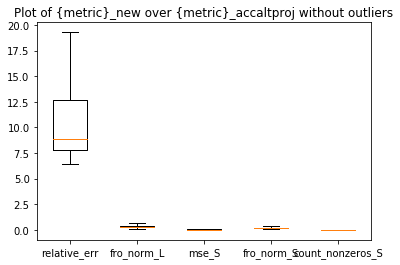

relative_err: 7/180 outliers
fro_norm_L: 13/180 outliers
mse_S: 25/180 outliers
fro_norm_S: 19/180 outliers
count_nonzeros_S: 35/180 outliers


In [82]:
relative_err = np.array([relative_err_new[i]/ relative_err_accaltproj[i] for i in range(len(relative_err_new))])
fro_norm_L = np.array([fro_norm_L_new[i]/ fro_norm_L_accaltproj[i] for i in range(len(fro_norm_L_new))])
mse_S = np.array([mse_S_new[i]/ mse_S_accaltproj[i] for i in range(len(mse_S_new))])
fro_norm_S = np.array([fro_norm_S_new[i]/ fro_norm_S_accaltproj[i] for i in range(len(fro_norm_S_new))])
count_nonzeros_S = np.array([count_nonzeros_S_new[i]/ count_nonzeros_S_accaltproj[i] for i in range(len(count_nonzeros_S_new))])
d = {"relative_err": relative_err \
    , "fro_norm_L": fro_norm_L \
    , "mse_S": mse_S \
    , "fro_norm_S": fro_norm_S \
    , "count_nonzeros_S": count_nonzeros_S
    }

fig, ax = plt.subplots()
ax.boxplot(d.values())
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_accaltproj")
plt.show()

fig, ax = plt.subplots()
ax.boxplot(d.values(), showfliers=False)
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_accaltproj without outliers")
plt.show()

for key, val in d.items():
    print(f"{key}: {count_outliers(d[key])}/{len(relative_err)} outliers")

In [83]:
print("P-values from test of mean with H1: _new/_accaltproj < 1")
# print("*Note: values are log-transformed before deriving p-values \n")
for key, val in d.items():
    print(f'{key}: ', stats.ttest_1samp(val, 1, alternative='less').pvalue)

P-values from test of mean with H1: _new/_accaltproj < 1
relative_err:  1.0
fro_norm_L:  2.2190194267826478e-105
mse_S:  4.084855830426535e-174
fro_norm_S:  2.501700880236558e-143
count_nonzeros_S:  0.0


#### Evaluating unrolled network on test dataset

In [84]:
out_bftrain_ontest2, out_hat_ontest2 = get_net_outputs(net2, LearnedAAP(max_iter), r, test2)
out_accaltproj_ontest2 = []
out_ircur_ontest2 = []
for (L_true, S_true, M_true) in test2:
    loss0, L0, S0 = AccAltProj(M_true, r, 1e-06, torch.tensor(0.7), max_iter)
    out_accaltproj_ontest2.append((L0, S0))
    loss0, L0, S0 = IRCUR(M_true, r, 1e-06, torch.tensor(0.7), 3, max_iter*2)
    out_ircur_ontest2.append((L0, S0))

/Users/elitanzc/Github/FYP/helper.py:254: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mat1 = (torch.tensor(mat1) == 0)
/Users/elitanzc/Github/FYP/helper.py:255: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mat2 = (torch.tensor(mat2) == 0)


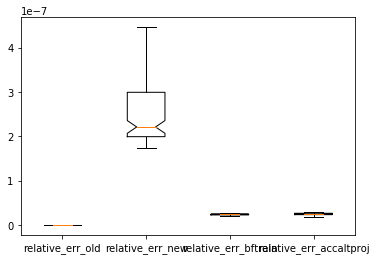

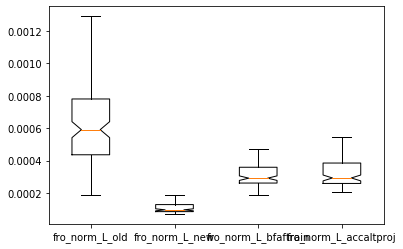

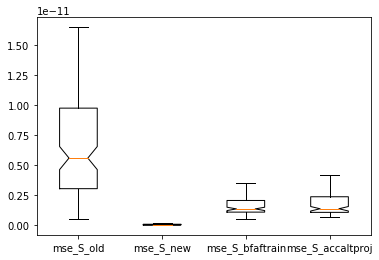

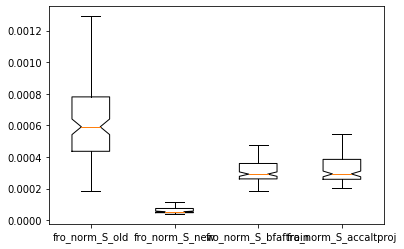

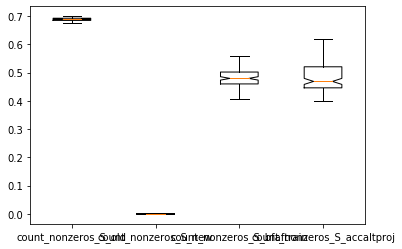

In [85]:
metrics = get_metrics(test2, out_ircur_ontest2, out_bftrain_ontest2, out_hat_ontest2)
fro_norm_L_old, mse_S_old, fro_norm_S_old, count_nonzeros_S_old, relative_err_old, \
    fro_norm_L_new, mse_S_new, fro_norm_S_new, count_nonzeros_S_new, relative_err_new, \
    fro_norm_L_bftrain, mse_S_bftrain, fro_norm_S_bftrain, count_nonzeros_S_bftrain, relative_err_bftrain \
        = metrics.values()
fro_norm_L_accaltproj, mse_S_accaltproj, fro_norm_S_accaltproj, count_nonzeros_S_accaltproj, relative_err_accaltproj \
    = list(get_metrics(test2, out_accaltproj_ontest2, out_bftrain_ontest2, out_hat_ontest2).values())[:5]

fig, ax = plt.subplots()
ax.boxplot([relative_err_old, relative_err_new, relative_err_bftrain, relative_err_accaltproj], notch = True, showfliers=False)
ax.set_xticklabels(["relative_err_old", "relative_err_new", "relative_err_bftrain", "relative_err_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([fro_norm_L_old, fro_norm_L_new, fro_norm_L_bftrain, fro_norm_L_accaltproj], notch = True, showfliers=False)
ax.set_xticklabels(["fro_norm_L_old", "fro_norm_L_new", "fro_norm_L_bfaftrain", "fro_norm_L_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([mse_S_old, mse_S_new, mse_S_bftrain, mse_S_accaltproj], notch = True, showfliers=False)
ax.set_xticklabels(["mse_S_old", "mse_S_new", "mse_S_bfaftrain", "mse_S_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([fro_norm_S_old, fro_norm_S_new, fro_norm_S_bftrain, fro_norm_S_accaltproj], notch = True, showfliers=False)
ax.set_xticklabels(["fro_norm_S_old", "fro_norm_S_new", "fro_norm_S_bfaftrain", "fro_norm_S_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([count_nonzeros_S_old, count_nonzeros_S_new, count_nonzeros_S_bftrain, count_nonzeros_S_accaltproj], notch = True, showfliers=False)
ax.set_xticklabels(["count_nonzeros_S_old", "count_nonzeros_S_new", "count_nonzeros_S_bfaftrain", "count_nonzeros_S_accaltproj"])
plt.show()

In [86]:
print("P-values from test of mean with H1: _new < _old")
print("relative_err_new, relative_err_old: ", stats.ttest_rel(relative_err_new, relative_err_old, alternative='less').pvalue)
print("fro_norm_L_new, fro_norm_L_old: ", stats.ttest_rel(fro_norm_L_new, fro_norm_L_old, alternative='less').pvalue)
print("mse_S_new, mse_S_old: ", stats.ttest_rel(mse_S_new, mse_S_old, alternative='less').pvalue)
print("fro_norm_S_new, fro_norm_S_old: ", stats.ttest_rel(fro_norm_S_new, fro_norm_S_old, alternative='less').pvalue)
print("count_nonzeros_S_new, count_nonzeros_S_old: ", stats.ttest_rel(count_nonzeros_S_new, count_nonzeros_S_old, alternative='less').pvalue)
print()
print("P-values from test of mean with H1: _new < _accaltproj")
print("relative_err_new, relative_err_accaltproj: ", stats.ttest_rel(relative_err_new, relative_err_accaltproj, alternative='less').pvalue)
print("fro_norm_L_new, fro_norm_L_accaltproj: ", stats.ttest_rel(fro_norm_L_new, fro_norm_L_accaltproj, alternative='less').pvalue)
print("mse_S_new, mse_S_accaltproj: ", stats.ttest_rel(mse_S_new, mse_S_accaltproj, alternative='less').pvalue)
print("fro_norm_S_new, fro_norm_S_accaltproj: ", stats.ttest_rel(fro_norm_S_new, fro_norm_S_accaltproj, alternative='less').pvalue)
print("count_nonzeros_S_new, count_nonzeros_S_accaltproj: ", stats.ttest_rel(count_nonzeros_S_new, count_nonzeros_S_accaltproj, alternative='less').pvalue)
print()
print("relative_err_new, relative_err_bftrain: ", stats.ttest_rel(relative_err_new, relative_err_bftrain, alternative='less').pvalue)
print("fro_norm_L_new, fro_norm_L_bftrain: ", stats.ttest_rel(fro_norm_L_new, fro_norm_L_bftrain, alternative='less').pvalue)
print("mse_S_new, mse_S_bftrain: ", stats.ttest_rel(mse_S_new, mse_S_bftrain, alternative='less').pvalue)
print("fro_norm_S_new, fro_norm_S_bftrain: ", stats.ttest_rel(fro_norm_S_new, fro_norm_S_bftrain, alternative='less').pvalue)
print("count_nonzeros_S_new, count_nonzeros_S_bftrain: ", stats.ttest_rel(count_nonzeros_S_new, count_nonzeros_S_bftrain, alternative='less').pvalue)

# print("*Note: values are log-transformed before deriving p-values")
# print()
# print("relative_err_new, relative_err_old: ", stats.ttest_rel(np.log(relative_err_new), np.log(relative_err_old), alternative='less').pvalue)
# print("fro_norm_L_new, fro_norm_L_old: ", stats.ttest_rel(np.log(fro_norm_L_new), np.log(fro_norm_L_old), alternative='less').pvalue)
# print("mse_S_new, mse_S_old: ", stats.ttest_rel(np.log(mse_S_new), np.log(mse_S_old), alternative='less').pvalue)
# print("fro_norm_S_new, fro_norm_S_old: ", stats.ttest_rel(np.log(fro_norm_S_new), np.log(fro_norm_S_old), alternative='less').pvalue)
# print("count_nonzeros_S_new, count_nonzeros_S_old: ", stats.ttest_rel(np.log(count_nonzeros_S_new), np.log(count_nonzeros_S_old), alternative='less').pvalue)
# print()
# print("P-values from test of mean with H1: _new < _accaltproj")
# print("relative_err_new, relative_err_accaltproj: ", stats.ttest_rel(np.log(relative_err_new), np.log(relative_err_accaltproj), alternative='less').pvalue)
# print("fro_norm_L_new, fro_norm_L_accaltproj: ", stats.ttest_rel(np.log(fro_norm_L_new), np.log(fro_norm_L_accaltproj), alternative='less').pvalue)
# print("mse_S_new, mse_S_accaltproj: ", stats.ttest_rel(np.log(mse_S_new), np.log(mse_S_accaltproj), alternative='less').pvalue)
# print("fro_norm_S_new, fro_norm_S_accaltproj: ", stats.ttest_rel(np.log(fro_norm_S_new), np.log(fro_norm_S_accaltproj), alternative='less').pvalue)
# print("count_nonzeros_S_new, count_nonzeros_S_accaltproj: ", stats.ttest_rel(np.log(count_nonzeros_S_new), np.log(count_nonzeros_S_accaltproj), alternative='less').pvalue)
# print()
# print("relative_err_new, relative_err_bftrain: ", stats.ttest_rel(np.log(relative_err_new), np.log(relative_err_bftrain), alternative='less').pvalue)
# print("fro_norm_L_new, fro_norm_L_bftrain: ", stats.ttest_rel(np.log(fro_norm_L_new), np.log(fro_norm_L_bftrain), alternative='less').pvalue)
# print("mse_S_new, mse_S_bftrain: ", stats.ttest_rel(np.log(mse_S_new), np.log(mse_S_bftrain), alternative='less').pvalue)
# print("fro_norm_S_new, fro_norm_S_bftrain: ", stats.ttest_rel(np.log(fro_norm_S_new), np.log(fro_norm_S_bftrain), alternative='less').pvalue)
# print("count_nonzeros_S_new, count_nonzeros_S_bftrain: ", stats.ttest_rel(np.log(count_nonzeros_S_new), np.log(count_nonzeros_S_bftrain), alternative='less').pvalue)

P-values from test of mean with H1: _new < _old
relative_err_new, relative_err_old:  1.0
fro_norm_L_new, fro_norm_L_old:  0.03682869778537956
mse_S_new, mse_S_old:  0.07605557948087056
fro_norm_S_new, fro_norm_S_old:  0.0366347145375873
count_nonzeros_S_new, count_nonzeros_S_old:  2.475096965750534e-238

P-values from test of mean with H1: _new < _accaltproj
relative_err_new, relative_err_accaltproj:  1.0
fro_norm_L_new, fro_norm_L_accaltproj:  4.147600200148449e-31
mse_S_new, mse_S_accaltproj:  3.5143251789318664e-17
fro_norm_S_new, fro_norm_S_accaltproj:  2.473104162603681e-38
count_nonzeros_S_new, count_nonzeros_S_accaltproj:  6.333995322957237e-119

relative_err_new, relative_err_bftrain:  1.0
fro_norm_L_new, fro_norm_L_bftrain:  1.9594860846056093e-34
mse_S_new, mse_S_bftrain:  1.5232325312349356e-17
fro_norm_S_new, fro_norm_S_bftrain:  1.9836609000801839e-41
count_nonzeros_S_new, count_nonzeros_S_bftrain:  1.2848754559115275e-124


/var/folders/st/_q3p7lz50mncs1x1m22w92gc0000gn/T/ipykernel_9004/2174885101.py:1: RuntimeWarning: divide by zero encountered in true_divide
  relative_err = np.array([relative_err_new[i]/ relative_err_old[i] for i in range(len(relative_err_new))])
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/lib/function_base.py:4486: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


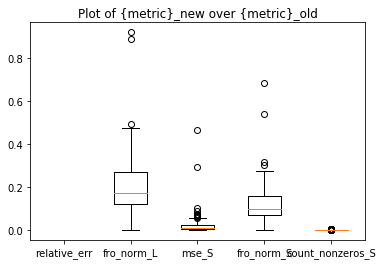

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/lib/function_base.py:4486: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


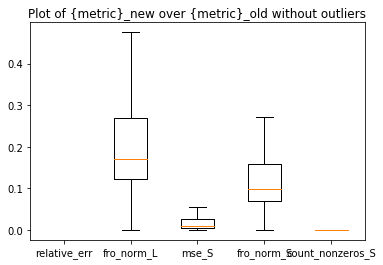

relative_err: 0/120 outliers
fro_norm_L: 3/120 outliers
mse_S: 13/120 outliers
fro_norm_S: 4/120 outliers
count_nonzeros_S: 23/120 outliers


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/lib/function_base.py:4486: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


In [87]:
relative_err = np.array([relative_err_new[i]/ relative_err_old[i] for i in range(len(relative_err_new))])
fro_norm_L = np.array([fro_norm_L_new[i]/ fro_norm_L_old[i] for i in range(len(fro_norm_L_new))])
mse_S = np.array([mse_S_new[i]/ mse_S_old[i] for i in range(len(mse_S_new))])
fro_norm_S = np.array([fro_norm_S_new[i]/ fro_norm_S_old[i] for i in range(len(fro_norm_S_new))])
count_nonzeros_S = np.array([count_nonzeros_S_new[i]/ count_nonzeros_S_old[i] for i in range(len(count_nonzeros_S_new))])
d = {"relative_err": relative_err \
    , "fro_norm_L": fro_norm_L \
    , "mse_S": mse_S \
    , "fro_norm_S": fro_norm_S \
    , "count_nonzeros_S": count_nonzeros_S
    }

fig, ax = plt.subplots()
ax.boxplot(d.values())
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_old")
plt.show()

fig, ax = plt.subplots()
ax.boxplot(d.values(), showfliers=False)
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_old without outliers")
plt.show()

for key, val in d.items():
    print(f"{key}: {count_outliers(d[key])}/{len(relative_err)} outliers")

In [88]:
print("P-values from test of mean with H1: _new/_old < 1")
# print("*Note: values are log-transformed before deriving p-values \n")
for key, val in d.items():
    print(f'{key}: ', stats.ttest_1samp(val, 1, alternative='less').pvalue)

P-values from test of mean with H1: _new/_old < 1
relative_err:  nan
fro_norm_L:  7.912781142857109e-92
mse_S:  7.79516337461793e-154
fro_norm_S:  4.6205725018521265e-118
count_nonzeros_S:  0.0


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1182: RuntimeWarning: invalid value encountered in subtract
  a_zero_mean = a - mean


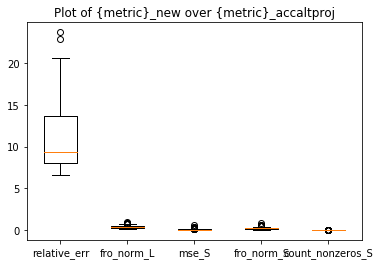

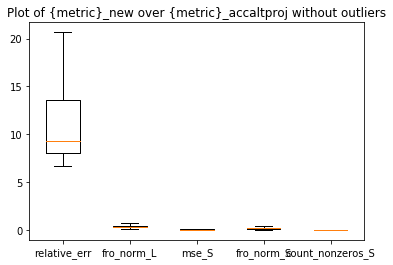

relative_err: 2/120 outliers
fro_norm_L: 7/120 outliers
mse_S: 17/120 outliers
fro_norm_S: 11/120 outliers
count_nonzeros_S: 27/120 outliers


In [91]:
relative_err = np.array([relative_err_new[i]/ relative_err_accaltproj[i] for i in range(len(relative_err_new))])
fro_norm_L = np.array([fro_norm_L_new[i]/ fro_norm_L_accaltproj[i] for i in range(len(fro_norm_L_new))])
mse_S = np.array([mse_S_new[i]/ mse_S_accaltproj[i] for i in range(len(mse_S_new))])
fro_norm_S = np.array([fro_norm_S_new[i]/ fro_norm_S_accaltproj[i] for i in range(len(fro_norm_S_new))])
count_nonzeros_S = np.array([count_nonzeros_S_new[i]/ count_nonzeros_S_accaltproj[i] for i in range(len(count_nonzeros_S_new))])
d = {"relative_err": relative_err \
    , "fro_norm_L": fro_norm_L \
    , "mse_S": mse_S \
    , "fro_norm_S": fro_norm_S \
    , "count_nonzeros_S": count_nonzeros_S
    }

fig, ax = plt.subplots()
ax.boxplot(d.values())
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_accaltproj")
plt.show()

fig, ax = plt.subplots()
ax.boxplot(d.values(), showfliers=False)
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_accaltproj without outliers")
plt.show()

for key, val in d.items():
    print(f"{key}: {count_outliers(d[key])}/{len(relative_err)} outliers")

In [92]:
print("P-values from test of mean with H1: _new/_accaltproj < 1")
# print("*Note: values are log-transformed before deriving p-values \n")
for key, val in d.items():
    print(f'{key}: ', stats.ttest_1samp(val, 1, alternative='less').pvalue)

P-values from test of mean with H1: _new/_accaltproj < 1
relative_err:  1.0
fro_norm_L:  4.1691490344266134e-69
mse_S:  1.1807215284116804e-124
fro_norm_S:  6.5447647488305e-96
count_nonzeros_S:  0.0


In [93]:
print(np.median(count_nonzeros_S_new), np.mean(count_nonzeros_S_new))
print(np.median(count_nonzeros_S_accaltproj), np.mean(count_nonzeros_S_accaltproj))

0.0 0.0003070667
0.46936 0.48471946


### Scenario 3:
**alpha = 0.01** (lower sparsity), **c = 1**, r = 2, dimension = 250x250

gamma=7.195e-01; beta=1.112e-01

*** ***

In [39]:
## ======================== 0. set constants ========================
# d1 = 250                   # num. of rows
# d2 = 250                   # num. of columns
# max_iter = 100              # num. of layers trained
alpha_true = 0.01
c_true = 1
# r = 2
# dataset_size = 300

## ======================== 1. generate data ========================
train3, test3 =  generate_train_test(dataset_size, r, d1, d2, alpha_true, c_true)

train dataset size: 180
test dataset size: 120


#### Training

In [40]:
## ======================== 2. estimations by classical ========================
train_est3 = []
for i, (L_true, S_true, M_true) in enumerate(train3):
    loss, L0, S0 = IRCUR(M_true, r, 1e-06, torch.tensor(0.7), 3, max_iter*2)
    train_est3.append((L0, S0, M_true))

In [41]:
## ======================== 3. train unrolled network with estimated data ========================
net3, params_bftrain3, params_aftrain3, l0_norm_of_S_Shat3 = train_nn(LearnedAAP(max_iter), r \
                                                                    , lr=2e-02, weight_decay=0 \
                                                                    , nepochs=5, dataset=train_est3)

[Parameter containing:
tensor(7.154e-01, requires_grad=True), Parameter containing:
tensor(4.249e-02, requires_grad=True)]
tensor(-3.319e-08) tensor(-1.665e-08)
Epoch 1/5 at cost=3.2402396321629112e-09
[Parameter containing:
tensor(7.315e-01, requires_grad=True), Parameter containing:
tensor(5.665e-02, requires_grad=True)]
tensor(-1.073e-07) tensor(-3.749e-08)
Epoch 1/5 at cost=1.232763113812041e-09
[Parameter containing:
tensor(7.437e-01, requires_grad=True), Parameter containing:
tensor(6.700e-02, requires_grad=True)]
tensor(-1.458e-12) tensor(-3.904e-13)
Epoch 1/5 at cost=5.936575120379928e-10
[Parameter containing:
tensor(7.535e-01, requires_grad=True), Parameter containing:
tensor(7.511e-02, requires_grad=True)]
tensor(-1.811e-13) tensor(-6.463e-14)
Epoch 1/5 at cost=2.982093239012329e-09
[Parameter containing:
tensor(7.616e-01, requires_grad=True), Parameter containing:
tensor(8.170e-02, requires_grad=True)]
tensor(-8.525e-13) tensor(-2.848e-13)
Epoch 1/5 at cost=1.51032375494963

#### Evaluating unrolled network on train dataset

In [42]:
out_bftrain3, out_hat3 = get_net_outputs(net3, LearnedAAP(max_iter), r, train3)
out_accaltproj3 = []
for i, (L_true, S_true, M_true) in enumerate(train3):
    loss, L0, S0 = AccAltProj(M_true, r, 1e-06, torch.tensor(0.7), max_iter)
    out_accaltproj3.append((L0, S0))

/Users/elitanzc/Github/FYP/helper.py:254: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mat1 = (torch.tensor(mat1) == 0)
/Users/elitanzc/Github/FYP/helper.py:255: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mat2 = (torch.tensor(mat2) == 0)


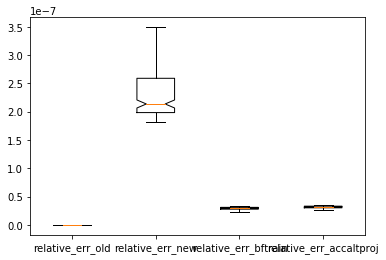

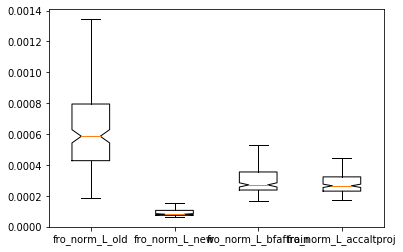

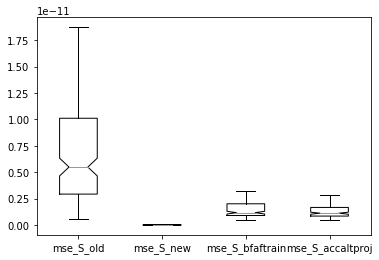

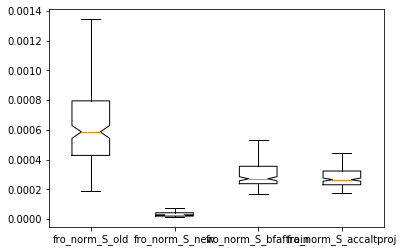

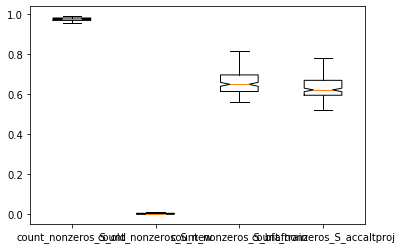

In [43]:
metrics = get_metrics(train3, [x[:2] for x in train_est3], out_bftrain3, out_hat3)
fro_norm_L_old, mse_S_old, fro_norm_S_old, count_nonzeros_S_old, relative_err_old, \
    fro_norm_L_new, mse_S_new, fro_norm_S_new, count_nonzeros_S_new, relative_err_new, \
    fro_norm_L_bftrain, mse_S_bftrain, fro_norm_S_bftrain, count_nonzeros_S_bftrain, relative_err_bftrain \
        = metrics.values()
fro_norm_L_accaltproj, mse_S_accaltproj, fro_norm_S_accaltproj, count_nonzeros_S_accaltproj, relative_err_accaltproj \
    = list(get_metrics(train3, out_accaltproj3, out_bftrain3, out_hat3).values())[:5]

fig, ax = plt.subplots()
ax.boxplot([relative_err_old, relative_err_new, relative_err_bftrain, relative_err_accaltproj], notch = True, showfliers=False)
ax.set_xticklabels(["relative_err_old", "relative_err_new", "relative_err_bftrain", "relative_err_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([fro_norm_L_old, fro_norm_L_new, fro_norm_L_bftrain, fro_norm_L_accaltproj], notch = True, showfliers=False)
ax.set_xticklabels(["fro_norm_L_old", "fro_norm_L_new", "fro_norm_L_bfaftrain", "fro_norm_L_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([mse_S_old, mse_S_new, mse_S_bftrain, mse_S_accaltproj], notch = True, showfliers=False)
ax.set_xticklabels(["mse_S_old", "mse_S_new", "mse_S_bfaftrain", "mse_S_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([fro_norm_S_old, fro_norm_S_new, fro_norm_S_bftrain, fro_norm_S_accaltproj], notch = True, showfliers=False)
ax.set_xticklabels(["fro_norm_S_old", "fro_norm_S_new", "fro_norm_S_bfaftrain", "fro_norm_S_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([count_nonzeros_S_old, count_nonzeros_S_new, count_nonzeros_S_bftrain, count_nonzeros_S_accaltproj], notch = True, showfliers=False)
ax.set_xticklabels(["count_nonzeros_S_old", "count_nonzeros_S_new", "count_nonzeros_S_bfaftrain", "count_nonzeros_S_accaltproj"])
plt.show()

In [44]:
print("P-values from test of mean with H1: _new < _old")
print("relative_err_new, relative_err_old: ", stats.ttest_rel(relative_err_new, relative_err_old, alternative='less').pvalue)
print("fro_norm_L_new, fro_norm_L_old: ", stats.ttest_rel(fro_norm_L_new, fro_norm_L_old, alternative='less').pvalue)
print("mse_S_new, mse_S_old: ", stats.ttest_rel(mse_S_new, mse_S_old, alternative='less').pvalue)
print("fro_norm_S_new, fro_norm_S_old: ", stats.ttest_rel(fro_norm_S_new, fro_norm_S_old, alternative='less').pvalue)
print("count_nonzeros_S_new, count_nonzeros_S_old: ", stats.ttest_rel(count_nonzeros_S_new, count_nonzeros_S_old, alternative='less').pvalue)
print()
print("P-values from test of mean with H1: _new < _accaltproj")
print("relative_err_new, relative_err_accaltproj: ", stats.ttest_rel(relative_err_new, relative_err_accaltproj, alternative='less').pvalue)
print("fro_norm_L_new, fro_norm_L_accaltproj: ", stats.ttest_rel(fro_norm_L_new, fro_norm_L_accaltproj, alternative='less').pvalue)
print("mse_S_new, mse_S_accaltproj: ", stats.ttest_rel(mse_S_new, mse_S_accaltproj, alternative='less').pvalue)
print("fro_norm_S_new, fro_norm_S_accaltproj: ", stats.ttest_rel(fro_norm_S_new, fro_norm_S_accaltproj, alternative='less').pvalue)
print("count_nonzeros_S_new, count_nonzeros_S_accaltproj: ", stats.ttest_rel(count_nonzeros_S_new, count_nonzeros_S_accaltproj, alternative='less').pvalue)
print()
print("relative_err_new, relative_err_bftrain: ", stats.ttest_rel(relative_err_new, relative_err_bftrain, alternative='less').pvalue)
print("fro_norm_L_new, fro_norm_L_bftrain: ", stats.ttest_rel(fro_norm_L_new, fro_norm_L_bftrain, alternative='less').pvalue)
print("mse_S_new, mse_S_bftrain: ", stats.ttest_rel(mse_S_new, mse_S_bftrain, alternative='less').pvalue)
print("fro_norm_S_new, fro_norm_S_bftrain: ", stats.ttest_rel(fro_norm_S_new, fro_norm_S_bftrain, alternative='less').pvalue)
print("count_nonzeros_S_new, count_nonzeros_S_bftrain: ", stats.ttest_rel(count_nonzeros_S_new, count_nonzeros_S_bftrain, alternative='less').pvalue)

# print("*Note: values are log-transformed before deriving p-values")
# print()
# print("relative_err_new, relative_err_old: ", stats.ttest_rel(np.log(relative_err_new), np.log(relative_err_old), alternative='less').pvalue)
# print("fro_norm_L_new, fro_norm_L_old: ", stats.ttest_rel(np.log(fro_norm_L_new), np.log(fro_norm_L_old), alternative='less').pvalue)
# print("mse_S_new, mse_S_old: ", stats.ttest_rel(np.log(mse_S_new), np.log(mse_S_old), alternative='less').pvalue)
# print("fro_norm_S_new, fro_norm_S_old: ", stats.ttest_rel(np.log(fro_norm_S_new), np.log(fro_norm_S_old), alternative='less').pvalue)
# print("count_nonzeros_S_new, count_nonzeros_S_old: ", stats.ttest_rel(np.log(count_nonzeros_S_new), np.log(count_nonzeros_S_old), alternative='less').pvalue)
# print()
# print("P-values from test of mean with H1: _new < _accaltproj")
# print("relative_err_new, relative_err_accaltproj: ", stats.ttest_rel(np.log(relative_err_new), np.log(relative_err_accaltproj), alternative='less').pvalue)
# print("fro_norm_L_new, fro_norm_L_accaltproj: ", stats.ttest_rel(np.log(fro_norm_L_new), np.log(fro_norm_L_accaltproj), alternative='less').pvalue)
# print("mse_S_new, mse_S_accaltproj: ", stats.ttest_rel(np.log(mse_S_new), np.log(mse_S_accaltproj), alternative='less').pvalue)
# print("fro_norm_S_new, fro_norm_S_accaltproj: ", stats.ttest_rel(np.log(fro_norm_S_new), np.log(fro_norm_S_accaltproj), alternative='less').pvalue)
# print("count_nonzeros_S_new, count_nonzeros_S_accaltproj: ", stats.ttest_rel(np.log(count_nonzeros_S_new), np.log(count_nonzeros_S_accaltproj), alternative='less').pvalue)
# print()
# print("relative_err_new, relative_err_bftrain: ", stats.ttest_rel(np.log(relative_err_new), np.log(relative_err_bftrain), alternative='less').pvalue)
# print("fro_norm_L_new, fro_norm_L_bftrain: ", stats.ttest_rel(np.log(fro_norm_L_new), np.log(fro_norm_L_bftrain), alternative='less').pvalue)
# print("mse_S_new, mse_S_bftrain: ", stats.ttest_rel(np.log(mse_S_new), np.log(mse_S_bftrain), alternative='less').pvalue)
# print("fro_norm_S_new, fro_norm_S_bftrain: ", stats.ttest_rel(np.log(fro_norm_S_new), np.log(fro_norm_S_bftrain), alternative='less').pvalue)
# print("count_nonzeros_S_new, count_nonzeros_S_bftrain: ", stats.ttest_rel(np.log(count_nonzeros_S_new), np.log(count_nonzeros_S_bftrain), alternative='less').pvalue)

P-values from test of mean with H1: _new < _old
relative_err_new, relative_err_old:  1.0
fro_norm_L_new, fro_norm_L_old:  6.021118148770331e-66
mse_S_new, mse_S_old:  6.272729363287732e-37
fro_norm_S_new, fro_norm_S_old:  2.2192616414054364e-72
count_nonzeros_S_new, count_nonzeros_S_old:  0.0

P-values from test of mean with H1: _new < _accaltproj
relative_err_new, relative_err_accaltproj:  1.0
fro_norm_L_new, fro_norm_L_accaltproj:  3.8486321401869774e-60
mse_S_new, mse_S_accaltproj:  1.3333888493314457e-33
fro_norm_S_new, fro_norm_S_accaltproj:  3.6200185685409437e-75
count_nonzeros_S_new, count_nonzeros_S_accaltproj:  8.591010968061618e-179

relative_err_new, relative_err_bftrain:  1.0
fro_norm_L_new, fro_norm_L_bftrain:  7.943641018623666e-59
mse_S_new, mse_S_bftrain:  1.3465442075518254e-32
fro_norm_S_new, fro_norm_S_bftrain:  5.677764695854693e-73
count_nonzeros_S_new, count_nonzeros_S_bftrain:  1.7355741755120364e-182


/var/folders/st/_q3p7lz50mncs1x1m22w92gc0000gn/T/ipykernel_9004/2174885101.py:1: RuntimeWarning: divide by zero encountered in true_divide
  relative_err = np.array([relative_err_new[i]/ relative_err_old[i] for i in range(len(relative_err_new))])
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/lib/function_base.py:4486: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


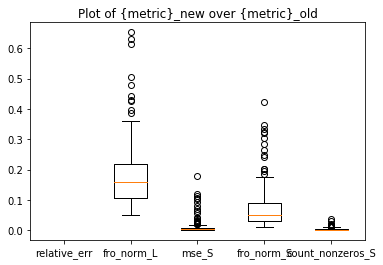

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/lib/function_base.py:4486: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


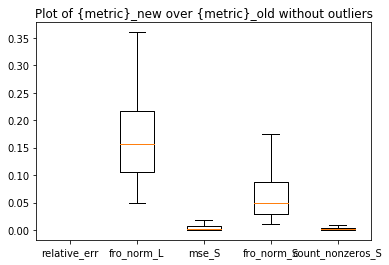

relative_err: 0/180 outliers
fro_norm_L: 10/180 outliers
mse_S: 27/180 outliers
fro_norm_S: 14/180 outliers
count_nonzeros_S: 22/180 outliers


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/lib/function_base.py:4486: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


In [45]:
relative_err = np.array([relative_err_new[i]/ relative_err_old[i] for i in range(len(relative_err_new))])
fro_norm_L = np.array([fro_norm_L_new[i]/ fro_norm_L_old[i] for i in range(len(fro_norm_L_new))])
mse_S = np.array([mse_S_new[i]/ mse_S_old[i] for i in range(len(mse_S_new))])
fro_norm_S = np.array([fro_norm_S_new[i]/ fro_norm_S_old[i] for i in range(len(fro_norm_S_new))])
count_nonzeros_S = np.array([count_nonzeros_S_new[i]/ count_nonzeros_S_old[i] for i in range(len(count_nonzeros_S_new))])
d = {"relative_err": relative_err \
    , "fro_norm_L": fro_norm_L \
    , "mse_S": mse_S \
    , "fro_norm_S": fro_norm_S \
    , "count_nonzeros_S": count_nonzeros_S
    }

fig, ax = plt.subplots()
ax.boxplot(d.values())
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_old")
plt.show()

fig, ax = plt.subplots()
ax.boxplot(d.values(), showfliers=False)
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_old without outliers")
plt.show()

for key, val in d.items():
    print(f"{key}: {count_outliers(d[key])}/{len(relative_err)} outliers")

In [46]:
print("P-values from test of mean with H1: _new/_old < 1")
# print("*Note: values are log-transformed before deriving p-values \n")
for key, val in d.items():
    print(f'{key}: ', stats.ttest_1samp(val, 1, alternative='less').pvalue)

P-values from test of mean with H1: _new/_old < 1
relative_err:  nan
fro_norm_L:  5.162294434445253e-162
mse_S:  1.5860422248721068e-291
fro_norm_S:  4.414846476217118e-201
count_nonzeros_S:  0.0


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1182: RuntimeWarning: invalid value encountered in subtract
  a_zero_mean = a - mean


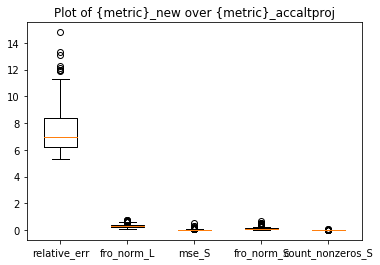

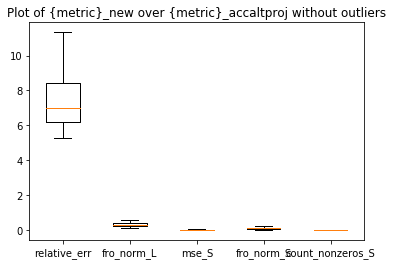

relative_err: 9/180 outliers
fro_norm_L: 12/180 outliers
mse_S: 29/180 outliers
fro_norm_S: 22/180 outliers
count_nonzeros_S: 25/180 outliers


In [47]:
relative_err = np.array([relative_err_new[i]/ relative_err_accaltproj[i] for i in range(len(relative_err_new))])
fro_norm_L = np.array([fro_norm_L_new[i]/ fro_norm_L_accaltproj[i] for i in range(len(fro_norm_L_new))])
mse_S = np.array([mse_S_new[i]/ mse_S_accaltproj[i] for i in range(len(mse_S_new))])
fro_norm_S = np.array([fro_norm_S_new[i]/ fro_norm_S_accaltproj[i] for i in range(len(fro_norm_S_new))])
count_nonzeros_S = np.array([count_nonzeros_S_new[i]/ count_nonzeros_S_accaltproj[i] for i in range(len(count_nonzeros_S_new))])
d = {"relative_err": relative_err \
    , "fro_norm_L": fro_norm_L \
    , "mse_S": mse_S \
    , "fro_norm_S": fro_norm_S \
    , "count_nonzeros_S": count_nonzeros_S
    }

fig, ax = plt.subplots()
ax.boxplot(d.values())
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_accaltproj")
plt.show()

fig, ax = plt.subplots()
ax.boxplot(d.values(), showfliers=False)
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_accaltproj without outliers")
plt.show()

for key, val in d.items():
    print(f"{key}: {count_outliers(d[key])}/{len(relative_err)} outliers")

In [48]:
print("P-values from test of mean with H1: _new/_accaltproj < 1")
#print("*Note: values are log-transformed before deriving p-values \n")
for key, val in d.items():
    print(f'{key}: ', stats.ttest_1samp(val, 1, alternative='less').pvalue)

P-values from test of mean with H1: _new/_accaltproj < 1
relative_err:  1.0
fro_norm_L:  8.670187999168267e-130
mse_S:  2.5620280674054602e-219
fro_norm_S:  2.5358309714058316e-164
count_nonzeros_S:  0.0


#### Evaluating unrolled network on test dataset

In [49]:
out_bftrain_ontest3, out_hat_ontest3 = get_net_outputs(net3, LearnedAAP(max_iter), r, test3)
out_accaltproj_ontest3 = []
out_ircur_ontest3 = []
for (L_true, S_true, M_true) in test3:
    loss0, L0, S0 = AccAltProj(M_true, r, 1e-06, torch.tensor(0.7), max_iter)
    out_accaltproj_ontest3.append((L0, S0))
    loss0, L0, S0 = IRCUR(M_true, r, 1e-06, torch.tensor(0.7), 3, max_iter*2)
    out_ircur_ontest3.append((L0, S0))

/Users/elitanzc/Github/FYP/helper.py:254: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mat1 = (torch.tensor(mat1) == 0)
/Users/elitanzc/Github/FYP/helper.py:255: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mat2 = (torch.tensor(mat2) == 0)


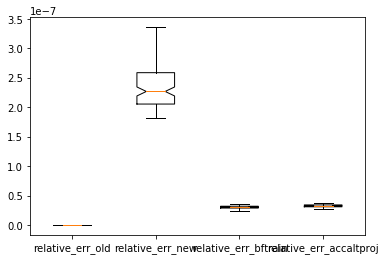

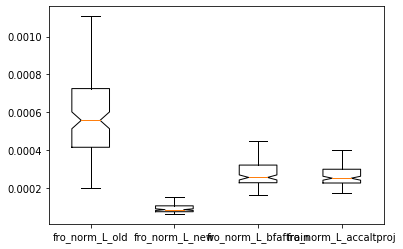

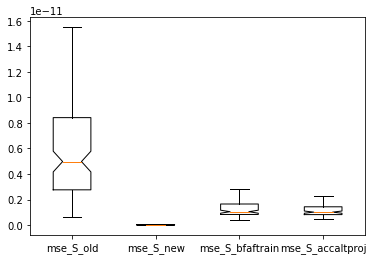

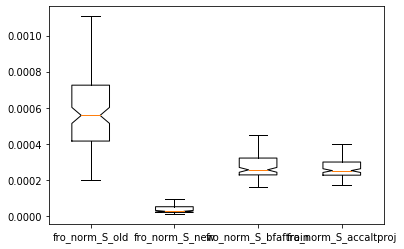

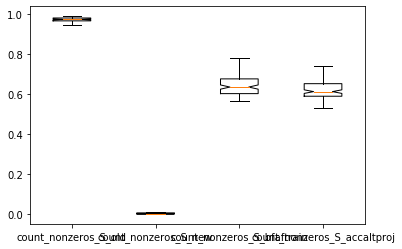

In [50]:
metrics = get_metrics(test3, out_ircur_ontest3, out_bftrain_ontest3, out_hat_ontest3)
fro_norm_L_old, mse_S_old, fro_norm_S_old, count_nonzeros_S_old, relative_err_old, \
    fro_norm_L_new, mse_S_new, fro_norm_S_new, count_nonzeros_S_new, relative_err_new, \
    fro_norm_L_bftrain, mse_S_bftrain, fro_norm_S_bftrain, count_nonzeros_S_bftrain, relative_err_bftrain \
        = metrics.values()
fro_norm_L_accaltproj, mse_S_accaltproj, fro_norm_S_accaltproj, count_nonzeros_S_accaltproj, relative_err_accaltproj \
    = list(get_metrics(test3, out_accaltproj_ontest3, out_bftrain_ontest3, out_hat_ontest3).values())[:5]

fig, ax = plt.subplots()
ax.boxplot([relative_err_old, relative_err_new, relative_err_bftrain, relative_err_accaltproj], notch = True, showfliers=False)
ax.set_xticklabels(["relative_err_old", "relative_err_new", "relative_err_bftrain", "relative_err_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([fro_norm_L_old, fro_norm_L_new, fro_norm_L_bftrain, fro_norm_L_accaltproj], notch = True, showfliers=False)
ax.set_xticklabels(["fro_norm_L_old", "fro_norm_L_new", "fro_norm_L_bfaftrain", "fro_norm_L_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([mse_S_old, mse_S_new, mse_S_bftrain, mse_S_accaltproj], notch = True, showfliers=False)
ax.set_xticklabels(["mse_S_old", "mse_S_new", "mse_S_bfaftrain", "mse_S_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([fro_norm_S_old, fro_norm_S_new, fro_norm_S_bftrain, fro_norm_S_accaltproj], notch = True, showfliers=False)
ax.set_xticklabels(["fro_norm_S_old", "fro_norm_S_new", "fro_norm_S_bfaftrain", "fro_norm_S_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([count_nonzeros_S_old, count_nonzeros_S_new, count_nonzeros_S_bftrain, count_nonzeros_S_accaltproj], notch = True, showfliers=False)
ax.set_xticklabels(["count_nonzeros_S_old", "count_nonzeros_S_new", "count_nonzeros_S_bfaftrain", "count_nonzeros_S_accaltproj"])
plt.show()

In [51]:
print("P-values from test of mean with H1: _new < _old")
print("relative_err_new, relative_err_old: ", stats.ttest_rel(relative_err_new, relative_err_old, alternative='less').pvalue)
print("fro_norm_L_new, fro_norm_L_old: ", stats.ttest_rel(fro_norm_L_new, fro_norm_L_old, alternative='less').pvalue)
print("mse_S_new, mse_S_old: ", stats.ttest_rel(mse_S_new, mse_S_old, alternative='less').pvalue)
print("fro_norm_S_new, fro_norm_S_old: ", stats.ttest_rel(fro_norm_S_new, fro_norm_S_old, alternative='less').pvalue)
print("count_nonzeros_S_new, count_nonzeros_S_old: ", stats.ttest_rel(count_nonzeros_S_new, count_nonzeros_S_old, alternative='less').pvalue)
print()
print("P-values from test of mean with H1: _new < _accaltproj")
print("relative_err_new, relative_err_accaltproj: ", stats.ttest_rel(relative_err_new, relative_err_accaltproj, alternative='less').pvalue)
print("fro_norm_L_new, fro_norm_L_accaltproj: ", stats.ttest_rel(fro_norm_L_new, fro_norm_L_accaltproj, alternative='less').pvalue)
print("mse_S_new, mse_S_accaltproj: ", stats.ttest_rel(mse_S_new, mse_S_accaltproj, alternative='less').pvalue)
print("fro_norm_S_new, fro_norm_S_accaltproj: ", stats.ttest_rel(fro_norm_S_new, fro_norm_S_accaltproj, alternative='less').pvalue)
print("count_nonzeros_S_new, count_nonzeros_S_accaltproj: ", stats.ttest_rel(count_nonzeros_S_new, count_nonzeros_S_accaltproj, alternative='less').pvalue)
print()
print("relative_err_new, relative_err_bftrain: ", stats.ttest_rel(relative_err_new, relative_err_bftrain, alternative='less').pvalue)
print("fro_norm_L_new, fro_norm_L_bftrain: ", stats.ttest_rel(fro_norm_L_new, fro_norm_L_bftrain, alternative='less').pvalue)
print("mse_S_new, mse_S_bftrain: ", stats.ttest_rel(mse_S_new, mse_S_bftrain, alternative='less').pvalue)
print("fro_norm_S_new, fro_norm_S_bftrain: ", stats.ttest_rel(fro_norm_S_new, fro_norm_S_bftrain, alternative='less').pvalue)
print("count_nonzeros_S_new, count_nonzeros_S_bftrain: ", stats.ttest_rel(count_nonzeros_S_new, count_nonzeros_S_bftrain, alternative='less').pvalue)

# print("*Note: values are log-transformed before deriving p-values")
# print()
# print("relative_err_new, relative_err_old: ", stats.ttest_rel(np.log(relative_err_new), np.log(relative_err_old), alternative='less').pvalue)
# print("fro_norm_L_new, fro_norm_L_old: ", stats.ttest_rel(np.log(fro_norm_L_new), np.log(fro_norm_L_old), alternative='less').pvalue)
# print("mse_S_new, mse_S_old: ", stats.ttest_rel(np.log(mse_S_new), np.log(mse_S_old), alternative='less').pvalue)
# print("fro_norm_S_new, fro_norm_S_old: ", stats.ttest_rel(np.log(fro_norm_S_new), np.log(fro_norm_S_old), alternative='less').pvalue)
# print("count_nonzeros_S_new, count_nonzeros_S_old: ", stats.ttest_rel(np.log(count_nonzeros_S_new), np.log(count_nonzeros_S_old), alternative='less').pvalue)
# print()
# print("P-values from test of mean with H1: _new < _accaltproj")
# print("relative_err_new, relative_err_accaltproj: ", stats.ttest_rel(np.log(relative_err_new), np.log(relative_err_accaltproj), alternative='less').pvalue)
# print("fro_norm_L_new, fro_norm_L_accaltproj: ", stats.ttest_rel(np.log(fro_norm_L_new), np.log(fro_norm_L_accaltproj), alternative='less').pvalue)
# print("mse_S_new, mse_S_accaltproj: ", stats.ttest_rel(np.log(mse_S_new), np.log(mse_S_accaltproj), alternative='less').pvalue)
# print("fro_norm_S_new, fro_norm_S_accaltproj: ", stats.ttest_rel(np.log(fro_norm_S_new), np.log(fro_norm_S_accaltproj), alternative='less').pvalue)
# print("count_nonzeros_S_new, count_nonzeros_S_accaltproj: ", stats.ttest_rel(np.log(count_nonzeros_S_new), np.log(count_nonzeros_S_accaltproj), alternative='less').pvalue)
# print()
# print("relative_err_new, relative_err_bftrain: ", stats.ttest_rel(np.log(relative_err_new), np.log(relative_err_bftrain), alternative='less').pvalue)
# print("fro_norm_L_new, fro_norm_L_bftrain: ", stats.ttest_rel(np.log(fro_norm_L_new), np.log(fro_norm_L_bftrain), alternative='less').pvalue)
# print("mse_S_new, mse_S_bftrain: ", stats.ttest_rel(np.log(mse_S_new), np.log(mse_S_bftrain), alternative='less').pvalue)
# print("fro_norm_S_new, fro_norm_S_bftrain: ", stats.ttest_rel(np.log(fro_norm_S_new), np.log(fro_norm_S_bftrain), alternative='less').pvalue)
# print("count_nonzeros_S_new, count_nonzeros_S_bftrain: ", stats.ttest_rel(np.log(count_nonzeros_S_new), np.log(count_nonzeros_S_bftrain), alternative='less').pvalue)

P-values from test of mean with H1: _new < _old
relative_err_new, relative_err_old:  1.0
fro_norm_L_new, fro_norm_L_old:  1.461723285833427e-40
mse_S_new, mse_S_old:  1.6197606133327108e-20
fro_norm_S_new, fro_norm_S_old:  1.0719658511155834e-44
count_nonzeros_S_new, count_nonzeros_S_old:  3.3803395565881204e-232

P-values from test of mean with H1: _new < _accaltproj
relative_err_new, relative_err_accaltproj:  1.0
fro_norm_L_new, fro_norm_L_accaltproj:  8.313129287551848e-37
mse_S_new, mse_S_accaltproj:  1.1594377982663696e-18
fro_norm_S_new, fro_norm_S_accaltproj:  9.165639334169968e-47
count_nonzeros_S_new, count_nonzeros_S_accaltproj:  1.5202197809927045e-119

relative_err_new, relative_err_bftrain:  1.0
fro_norm_L_new, fro_norm_L_bftrain:  1.5061017915927374e-36
mse_S_new, mse_S_bftrain:  2.565753972993341e-19
fro_norm_S_new, fro_norm_S_bftrain:  5.778028148740263e-46
count_nonzeros_S_new, count_nonzeros_S_bftrain:  1.92541736441942e-120


/var/folders/st/_q3p7lz50mncs1x1m22w92gc0000gn/T/ipykernel_9004/2174885101.py:1: RuntimeWarning: divide by zero encountered in true_divide
  relative_err = np.array([relative_err_new[i]/ relative_err_old[i] for i in range(len(relative_err_new))])
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/lib/function_base.py:4486: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


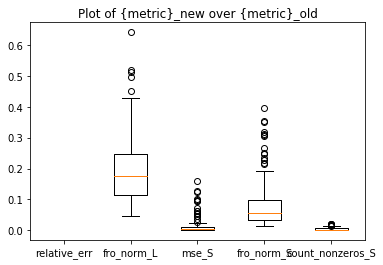

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/lib/function_base.py:4486: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


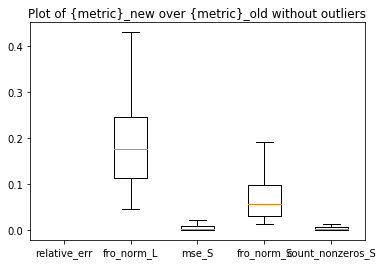

relative_err: 0/120 outliers
fro_norm_L: 5/120 outliers
mse_S: 16/120 outliers
fro_norm_S: 14/120 outliers
count_nonzeros_S: 9/120 outliers


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/lib/function_base.py:4486: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


In [52]:
relative_err = np.array([relative_err_new[i]/ relative_err_old[i] for i in range(len(relative_err_new))])
fro_norm_L = np.array([fro_norm_L_new[i]/ fro_norm_L_old[i] for i in range(len(fro_norm_L_new))])
mse_S = np.array([mse_S_new[i]/ mse_S_old[i] for i in range(len(mse_S_new))])
fro_norm_S = np.array([fro_norm_S_new[i]/ fro_norm_S_old[i] for i in range(len(fro_norm_S_new))])
count_nonzeros_S = np.array([count_nonzeros_S_new[i]/ count_nonzeros_S_old[i] for i in range(len(count_nonzeros_S_new))])
d = {"relative_err": relative_err \
    , "fro_norm_L": fro_norm_L \
    , "mse_S": mse_S \
    , "fro_norm_S": fro_norm_S \
    , "count_nonzeros_S": count_nonzeros_S
    }

fig, ax = plt.subplots()
ax.boxplot(d.values())
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_old")
plt.show()

fig, ax = plt.subplots()
ax.boxplot(d.values(), showfliers=False)
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_old without outliers")
plt.show()

for key, val in d.items():
    print(f"{key}: {count_outliers(d[key])}/{len(relative_err)} outliers")

In [53]:
print("P-values from test of mean with H1: _new/_old < 1")
# print("*Note: values are log-transformed before deriving p-values \n")
for key, val in d.items():
    print(f'{key}: ', stats.ttest_1samp(val, 1, alternative='less').pvalue)

P-values from test of mean with H1: _new/_old < 1
relative_err:  nan
fro_norm_L:  1.1831631598346242e-105
mse_S:  6.035405271950765e-185
fro_norm_S:  3.5501546454544355e-126
count_nonzeros_S:  4.997321413827828e-276


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1182: RuntimeWarning: invalid value encountered in subtract
  a_zero_mean = a - mean


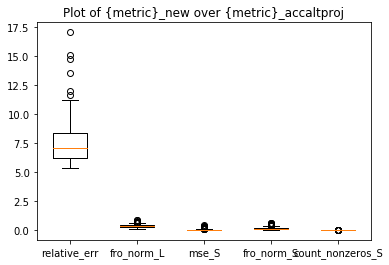

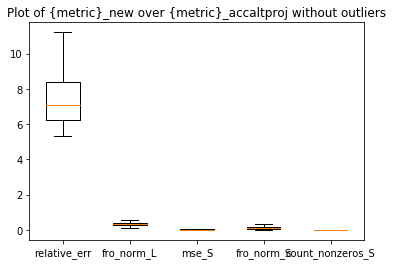

relative_err: 6/120 outliers
fro_norm_L: 10/120 outliers
mse_S: 17/120 outliers
fro_norm_S: 12/120 outliers
count_nonzeros_S: 8/120 outliers


In [54]:
relative_err = np.array([relative_err_new[i]/ relative_err_accaltproj[i] for i in range(len(relative_err_new))])
fro_norm_L = np.array([fro_norm_L_new[i]/ fro_norm_L_accaltproj[i] for i in range(len(fro_norm_L_new))])
mse_S = np.array([mse_S_new[i]/ mse_S_accaltproj[i] for i in range(len(mse_S_new))])
fro_norm_S = np.array([fro_norm_S_new[i]/ fro_norm_S_accaltproj[i] for i in range(len(fro_norm_S_new))])
count_nonzeros_S = np.array([count_nonzeros_S_new[i]/ count_nonzeros_S_accaltproj[i] for i in range(len(count_nonzeros_S_new))])
d = {"relative_err": relative_err \
    , "fro_norm_L": fro_norm_L \
    , "mse_S": mse_S \
    , "fro_norm_S": fro_norm_S \
    , "count_nonzeros_S": count_nonzeros_S
    }

fig, ax = plt.subplots()
ax.boxplot(d.values())
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_accaltproj")
plt.show()

fig, ax = plt.subplots()
ax.boxplot(d.values(), showfliers=False)
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_accaltproj without outliers")
plt.show()

for key, val in d.items():
    print(f"{key}: {count_outliers(d[key])}/{len(relative_err)} outliers")

In [55]:
print("P-values from test of mean with H1: _new/_accaltproj < 1")
#print("*Note: values are log-transformed before deriving p-values \n")
for key, val in d.items():
    print(f'{key}: ', stats.ttest_1samp(val, 1, alternative='less').pvalue)

P-values from test of mean with H1: _new/_accaltproj < 1
relative_err:  1.0
fro_norm_L:  2.376761966067826e-80
mse_S:  1.9322070895617577e-133
fro_norm_S:  1.0216650953593366e-99
count_nonzeros_S:  1.6732335685835585e-255


In [ ]:
print(np.median(count_nonzeros_S_new), np.mean(count_nonzeros_S_new))
print(np.median(count_nonzeros_S_accaltproj), np.mean(count_nonzeros_S_accaltproj))

### Scenario 4:
**alpha = 0.1** (higher sparsity), **c = 10**, r = 2, dimension = 250x250

gamma=7.359e-01; beta=4.489e-02

*** ***

In [56]:
## ======================== 0. set constants ========================
# d1 = 250                   # num. of rows
# d2 = 250                   # num. of columns
# max_iter = 100              # num. of layers trained
alpha_true = 0.1
c_true = 10
# r = 2
# dataset_size = 300

## ======================== 1. generate data ========================
train4, test4 =  generate_train_test(dataset_size, r, d1, d2, alpha_true, c_true)

train dataset size: 180
test dataset size: 120


#### Training

In [57]:
## ======================== 2. estimations by classical ========================
train_est4 = []
for i, (L_true, S_true, M_true) in enumerate(train4):
    loss, L0, S0 = IRCUR(M_true, r, 1e-06, torch.tensor(0.7), 3, max_iter*2)
    train_est4.append((L0, S0, M_true))

In [58]:
## ======================== 3. train unrolled network with estimated data ========================
net4, params_bftrain4, params_aftrain4, l0_norm_of_S_Shat4 = train_nn(LearnedAAP(max_iter), r \
                                                                    , lr=2e-02, weight_decay=0 \
                                                                    , nepochs=5, dataset=train_est4)

[Parameter containing:
tensor(7.002e-01, requires_grad=True), Parameter containing:
tensor(3.010e-02, requires_grad=True)]
tensor(-1.020e-10) tensor(-5.248e-11)
Epoch 1/5 at cost=2.8525327933071054e-11
[Parameter containing:
tensor(7.003e-01, requires_grad=True), Parameter containing:
tensor(3.016e-02, requires_grad=True)]
tensor(-1.468e-11) tensor(-6.860e-12)
Epoch 1/5 at cost=6.452065444417787e-12
[Parameter containing:
tensor(7.004e-01, requires_grad=True), Parameter containing:
tensor(3.020e-02, requires_grad=True)]
tensor(-1.330e-12) tensor(1.045e-12)
Epoch 1/5 at cost=4.437067033236097e-12
[Parameter containing:
tensor(7.005e-01, requires_grad=True), Parameter containing:
tensor(3.023e-02, requires_grad=True)]
tensor(-2.758e-11) tensor(-1.436e-11)
Epoch 1/5 at cost=3.0476550103020195e-12
[Parameter containing:
tensor(7.005e-01, requires_grad=True), Parameter containing:
tensor(3.026e-02, requires_grad=True)]
tensor(-9.337e-12) tensor(-7.264e-12)
Epoch 1/5 at cost=1.84754165091782

#### Evaluating unrolled network on train dataset

In [59]:
out_bftrain4, out_hat4 = get_net_outputs(net4, LearnedAAP(max_iter), r, train4)
out_accaltproj4 = []
for i, (L_true, S_true, M_true) in enumerate(train4):
    loss, L0, S0 = AccAltProj(M_true, r, 1e-06, torch.tensor(0.7), max_iter)
    out_accaltproj4.append((L0, S0))

/Users/elitanzc/Github/FYP/helper.py:254: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mat1 = (torch.tensor(mat1) == 0)
/Users/elitanzc/Github/FYP/helper.py:255: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mat2 = (torch.tensor(mat2) == 0)


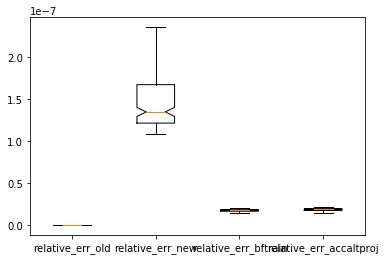

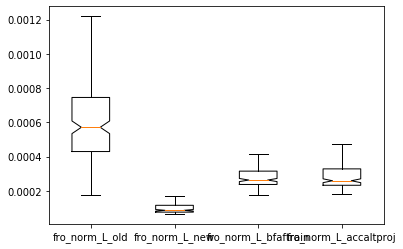

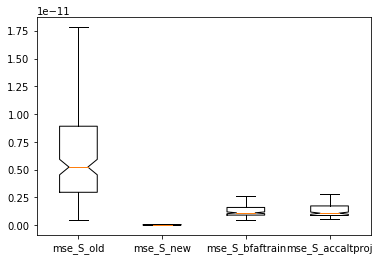

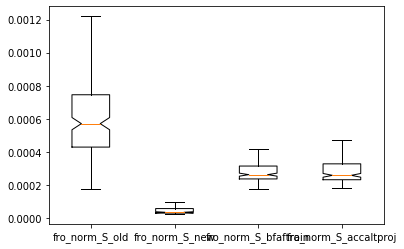

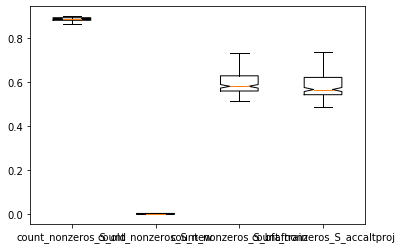

In [60]:
metrics = get_metrics(train4, [x[:2] for x in train_est4], out_bftrain4, out_hat4)
fro_norm_L_old, mse_S_old, fro_norm_S_old, count_nonzeros_S_old, relative_err_old, \
    fro_norm_L_new, mse_S_new, fro_norm_S_new, count_nonzeros_S_new, relative_err_new, \
    fro_norm_L_bftrain, mse_S_bftrain, fro_norm_S_bftrain, count_nonzeros_S_bftrain, relative_err_bftrain \
        = metrics.values()
fro_norm_L_accaltproj, mse_S_accaltproj, fro_norm_S_accaltproj, count_nonzeros_S_accaltproj, relative_err_accaltproj \
    = list(get_metrics(train4, out_accaltproj4, out_bftrain4, out_hat4).values())[:5]

fig, ax = plt.subplots()
ax.boxplot([relative_err_old, \
    relative_err_new, relative_err_bftrain, relative_err_accaltproj], notch = True, showfliers=False)
ax.set_xticklabels(["relative_err_old", \
    "relative_err_new", "relative_err_bftrain", "relative_err_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([fro_norm_L_old, fro_norm_L_new, fro_norm_L_bftrain, fro_norm_L_accaltproj], notch = True, showfliers=False)
ax.set_xticklabels(["fro_norm_L_old", "fro_norm_L_new", "fro_norm_L_bfaftrain", "fro_norm_L_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([mse_S_old, mse_S_new, mse_S_bftrain, mse_S_accaltproj], notch = True, showfliers=False)
ax.set_xticklabels(["mse_S_old", "mse_S_new", "mse_S_bfaftrain", "mse_S_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([fro_norm_S_old, fro_norm_S_new, fro_norm_S_bftrain, fro_norm_S_accaltproj], notch = True, showfliers=False)
ax.set_xticklabels(["fro_norm_S_old", "fro_norm_S_new", "fro_norm_S_bfaftrain", "fro_norm_S_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([count_nonzeros_S_old, count_nonzeros_S_new, count_nonzeros_S_bftrain, count_nonzeros_S_accaltproj], notch = True, showfliers=False)
ax.set_xticklabels(["count_nonzeros_S_old", "count_nonzeros_S_new", "count_nonzeros_S_bfaftrain", "count_nonzeros_S_accaltproj"])
plt.show()

In [61]:
print("P-values from test of mean with H1: _new < _old")
print("relative_err_new, relative_err_old: ", stats.ttest_rel(relative_err_new, relative_err_old, alternative='less').pvalue)
print("fro_norm_L_new, fro_norm_L_old: ", stats.ttest_rel(fro_norm_L_new, fro_norm_L_old, alternative='less').pvalue)
print("mse_S_new, mse_S_old: ", stats.ttest_rel(mse_S_new, mse_S_old, alternative='less').pvalue)
print("fro_norm_S_new, fro_norm_S_old: ", stats.ttest_rel(fro_norm_S_new, fro_norm_S_old, alternative='less').pvalue)
print("count_nonzeros_S_new, count_nonzeros_S_old: ", stats.ttest_rel(count_nonzeros_S_new, count_nonzeros_S_old, alternative='less').pvalue)
print()
print("P-values from test of mean with H1: _new < _accaltproj")
print("relative_err_new, relative_err_accaltproj: ", stats.ttest_rel(relative_err_new, relative_err_accaltproj, alternative='less').pvalue)
print("fro_norm_L_new, fro_norm_L_accaltproj: ", stats.ttest_rel(fro_norm_L_new, fro_norm_L_accaltproj, alternative='less').pvalue)
print("mse_S_new, mse_S_accaltproj: ", stats.ttest_rel(mse_S_new, mse_S_accaltproj, alternative='less').pvalue)
print("fro_norm_S_new, fro_norm_S_accaltproj: ", stats.ttest_rel(fro_norm_S_new, fro_norm_S_accaltproj, alternative='less').pvalue)
print("count_nonzeros_S_new, count_nonzeros_S_accaltproj: ", stats.ttest_rel(count_nonzeros_S_new, count_nonzeros_S_accaltproj, alternative='less').pvalue)
print()
print("relative_err_new, relative_err_bftrain: ", stats.ttest_rel(relative_err_new, relative_err_bftrain, alternative='less').pvalue)
print("fro_norm_L_new, fro_norm_L_bftrain: ", stats.ttest_rel(fro_norm_L_new, fro_norm_L_bftrain, alternative='less').pvalue)
print("mse_S_new, mse_S_bftrain: ", stats.ttest_rel(mse_S_new, mse_S_bftrain, alternative='less').pvalue)
print("fro_norm_S_new, fro_norm_S_bftrain: ", stats.ttest_rel(fro_norm_S_new, fro_norm_S_bftrain, alternative='less').pvalue)
print("count_nonzeros_S_new, count_nonzeros_S_bftrain: ", stats.ttest_rel(count_nonzeros_S_new, count_nonzeros_S_bftrain, alternative='less').pvalue)

# print("*Note: values are log-transformed before deriving p-values")
# print()
# print("relative_err_new, relative_err_old: ", stats.ttest_rel(np.log(relative_err_new), np.log(relative_err_old), alternative='less').pvalue)
# print("fro_norm_L_new, fro_norm_L_old: ", stats.ttest_rel(np.log(fro_norm_L_new), np.log(fro_norm_L_old), alternative='less').pvalue)
# print("mse_S_new, mse_S_old: ", stats.ttest_rel(np.log(mse_S_new), np.log(mse_S_old), alternative='less').pvalue)
# print("fro_norm_S_new, fro_norm_S_old: ", stats.ttest_rel(np.log(fro_norm_S_new), np.log(fro_norm_S_old), alternative='less').pvalue)
# print("count_nonzeros_S_new, count_nonzeros_S_old: ", stats.ttest_rel(np.log(count_nonzeros_S_new), np.log(count_nonzeros_S_old), alternative='less').pvalue)
# print()
# print("P-values from test of mean with H1: _new < _accaltproj")
# print("relative_err_new, relative_err_accaltproj: ", stats.ttest_rel(np.log(relative_err_new), np.log(relative_err_accaltproj), alternative='less').pvalue)
# print("fro_norm_L_new, fro_norm_L_accaltproj: ", stats.ttest_rel(np.log(fro_norm_L_new), np.log(fro_norm_L_accaltproj), alternative='less').pvalue)
# print("mse_S_new, mse_S_accaltproj: ", stats.ttest_rel(np.log(mse_S_new), np.log(mse_S_accaltproj), alternative='less').pvalue)
# print("fro_norm_S_new, fro_norm_S_accaltproj: ", stats.ttest_rel(np.log(fro_norm_S_new), np.log(fro_norm_S_accaltproj), alternative='less').pvalue)
# print("count_nonzeros_S_new, count_nonzeros_S_accaltproj: ", stats.ttest_rel(np.log(count_nonzeros_S_new), np.log(count_nonzeros_S_accaltproj), alternative='less').pvalue)
# print()
# print("relative_err_new, relative_err_bftrain: ", stats.ttest_rel(np.log(relative_err_new), np.log(relative_err_bftrain), alternative='less').pvalue)
# print("fro_norm_L_new, fro_norm_L_bftrain: ", stats.ttest_rel(np.log(fro_norm_L_new), np.log(fro_norm_L_bftrain), alternative='less').pvalue)
# print("mse_S_new, mse_S_bftrain: ", stats.ttest_rel(np.log(mse_S_new), np.log(mse_S_bftrain), alternative='less').pvalue)
# print("fro_norm_S_new, fro_norm_S_bftrain: ", stats.ttest_rel(np.log(fro_norm_S_new), np.log(fro_norm_S_bftrain), alternative='less').pvalue)
# print("count_nonzeros_S_new, count_nonzeros_S_bftrain: ", stats.ttest_rel(np.log(count_nonzeros_S_new), np.log(count_nonzeros_S_bftrain), alternative='less').pvalue)

P-values from test of mean with H1: _new < _old
relative_err_new, relative_err_old:  1.0
fro_norm_L_new, fro_norm_L_old:  3.513202099726746e-57
mse_S_new, mse_S_old:  2.2297950543648774e-25
fro_norm_S_new, fro_norm_S_old:  2.013184686900824e-62
count_nonzeros_S_new, count_nonzeros_S_old:  0.0

P-values from test of mean with H1: _new < _accaltproj
relative_err_new, relative_err_accaltproj:  1.0
fro_norm_L_new, fro_norm_L_accaltproj:  1.669079995939132e-53
mse_S_new, mse_S_accaltproj:  5.257566351358029e-27
fro_norm_S_new, fro_norm_S_accaltproj:  4.176394616087822e-66
count_nonzeros_S_new, count_nonzeros_S_accaltproj:  1.5700253664882953e-176

relative_err_new, relative_err_bftrain:  1.0
fro_norm_L_new, fro_norm_L_bftrain:  1.7545400603866008e-56
mse_S_new, mse_S_bftrain:  3.2401545726427285e-28
fro_norm_S_new, fro_norm_S_bftrain:  5.7721437022750256e-70
count_nonzeros_S_new, count_nonzeros_S_bftrain:  5.352631499649866e-184


/var/folders/st/_q3p7lz50mncs1x1m22w92gc0000gn/T/ipykernel_9004/2174885101.py:1: RuntimeWarning: divide by zero encountered in true_divide
  relative_err = np.array([relative_err_new[i]/ relative_err_old[i] for i in range(len(relative_err_new))])
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/lib/function_base.py:4486: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


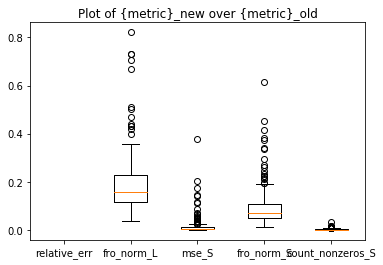

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/lib/function_base.py:4486: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


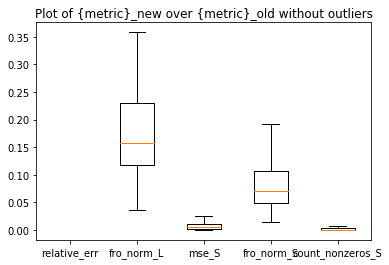

relative_err: 0/180 outliers
fro_norm_L: 13/180 outliers
mse_S: 23/180 outliers
fro_norm_S: 18/180 outliers
count_nonzeros_S: 18/180 outliers


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/lib/function_base.py:4486: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


In [62]:
relative_err = np.array([relative_err_new[i]/ relative_err_old[i] for i in range(len(relative_err_new))])
fro_norm_L = np.array([fro_norm_L_new[i]/ fro_norm_L_old[i] for i in range(len(fro_norm_L_new))])
mse_S = np.array([mse_S_new[i]/ mse_S_old[i] for i in range(len(mse_S_new))])
fro_norm_S = np.array([fro_norm_S_new[i]/ fro_norm_S_old[i] for i in range(len(fro_norm_S_new))])
count_nonzeros_S = np.array([count_nonzeros_S_new[i]/ count_nonzeros_S_old[i] for i in range(len(count_nonzeros_S_new))])
d = {"relative_err": relative_err \
    , "fro_norm_L": fro_norm_L \
    , "mse_S": mse_S \
    , "fro_norm_S": fro_norm_S \
    , "count_nonzeros_S": count_nonzeros_S
    }

fig, ax = plt.subplots()
ax.boxplot(d.values())
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_old")
plt.show()

fig, ax = plt.subplots()
ax.boxplot(d.values(), showfliers=False)
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_old without outliers")
plt.show()

for key, val in d.items():
    print(f"{key}: {count_outliers(d[key])}/{len(relative_err)} outliers")

In [63]:
print("P-values from test of mean with H1: _new/_old < 1")
# print("*Note: values are log-transformed before deriving p-values \n")
for key, val in d.items():
    print(f'{key}: ', stats.ttest_1samp(val, 1, alternative='less').pvalue)

P-values from test of mean with H1: _new/_old < 1
relative_err:  nan
fro_norm_L:  1.2989644316169091e-146
mse_S:  5.945546951153453e-252
fro_norm_S:  7.654131365195196e-187
count_nonzeros_S:  0.0


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1182: RuntimeWarning: invalid value encountered in subtract
  a_zero_mean = a - mean


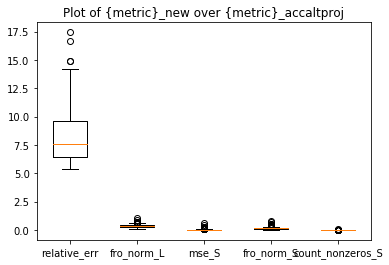

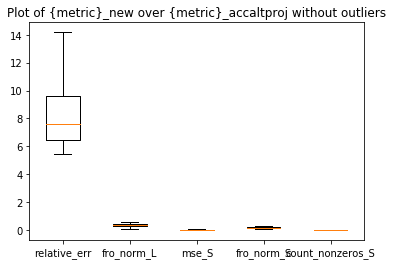

relative_err: 4/180 outliers
fro_norm_L: 15/180 outliers
mse_S: 27/180 outliers
fro_norm_S: 24/180 outliers
count_nonzeros_S: 20/180 outliers


In [64]:
relative_err = np.array([relative_err_new[i]/ relative_err_accaltproj[i] for i in range(len(relative_err_new))])
fro_norm_L = np.array([fro_norm_L_new[i]/ fro_norm_L_accaltproj[i] for i in range(len(fro_norm_L_new))])
mse_S = np.array([mse_S_new[i]/ mse_S_accaltproj[i] for i in range(len(mse_S_new))])
fro_norm_S = np.array([fro_norm_S_new[i]/ fro_norm_S_accaltproj[i] for i in range(len(fro_norm_S_new))])
count_nonzeros_S = np.array([count_nonzeros_S_new[i]/ count_nonzeros_S_accaltproj[i] for i in range(len(count_nonzeros_S_new))])
d = {"relative_err": relative_err \
    , "fro_norm_L": fro_norm_L \
    , "mse_S": mse_S \
    , "fro_norm_S": fro_norm_S \
    , "count_nonzeros_S": count_nonzeros_S
    }

fig, ax = plt.subplots()
ax.boxplot(d.values())
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_accaltproj")
plt.show()

fig, ax = plt.subplots()
ax.boxplot(d.values(), showfliers=False)
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_accaltproj without outliers")
plt.show()

for key, val in d.items():
    print(f"{key}: {count_outliers(d[key])}/{len(relative_err)} outliers")

In [65]:
print("P-values from test of mean with H1: _new/_accaltproj < 1")
#print("*Note: values are log-transformed before deriving p-values \n")
for key, val in d.items():
    print(f'{key}: ', stats.ttest_1samp(val, 1, alternative='less').pvalue)

P-values from test of mean with H1: _new/_accaltproj < 1
relative_err:  1.0
fro_norm_L:  4.972497691591915e-122
mse_S:  4.573073368895668e-201
fro_norm_S:  2.7231071948669353e-158
count_nonzeros_S:  0.0


#### Evaluating unrolled network on test dataset

In [66]:
out_bftrain_ontest4, out_hat_ontest4 = get_net_outputs(net4, LearnedAAP(max_iter), r, test4)
out_accaltproj_ontest4 = []
out_ircur_ontest4 = []
for (L_true, S_true, M_true) in test4:
    loss0, L0, S0 = AccAltProj(M_true, r, 1e-06, torch.tensor(0.7), max_iter)
    out_accaltproj_ontest4.append((L0, S0))
    loss0, L0, S0 = IRCUR(M_true, r, 1e-06, torch.tensor(0.7), 3, max_iter*2)
    out_ircur_ontest4.append((L0, S0))

/Users/elitanzc/Github/FYP/helper.py:254: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mat1 = (torch.tensor(mat1) == 0)
/Users/elitanzc/Github/FYP/helper.py:255: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mat2 = (torch.tensor(mat2) == 0)


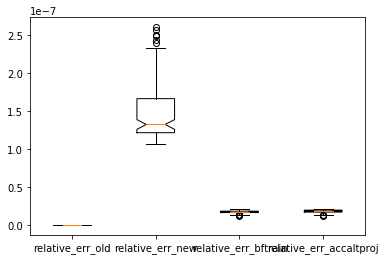

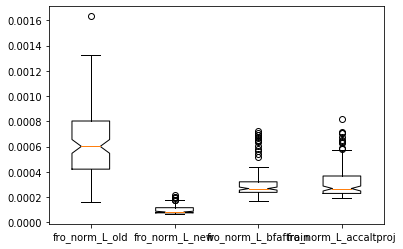

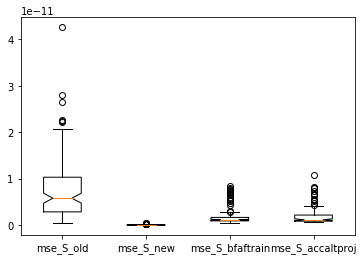

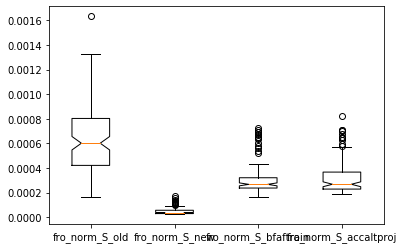

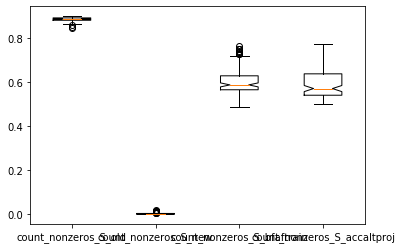

In [67]:
metrics = get_metrics(test4, out_ircur_ontest4, out_bftrain_ontest4, out_hat_ontest4)
fro_norm_L_old, mse_S_old, fro_norm_S_old, count_nonzeros_S_old, relative_err_old, \
    fro_norm_L_new, mse_S_new, fro_norm_S_new, count_nonzeros_S_new, relative_err_new, \
    fro_norm_L_bftrain, mse_S_bftrain, fro_norm_S_bftrain, count_nonzeros_S_bftrain, relative_err_bftrain \
        = metrics.values()
fro_norm_L_accaltproj, mse_S_accaltproj, fro_norm_S_accaltproj, count_nonzeros_S_accaltproj, relative_err_accaltproj \
    = list(get_metrics(test4, out_accaltproj_ontest4, out_bftrain_ontest4, out_hat_ontest4).values())[:5]

fig, ax = plt.subplots()
ax.boxplot([relative_err_old, relative_err_new, relative_err_bftrain, relative_err_accaltproj], notch = True)
ax.set_xticklabels(["relative_err_old", "relative_err_new", "relative_err_bftrain", "relative_err_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([fro_norm_L_old, fro_norm_L_new, fro_norm_L_bftrain, fro_norm_L_accaltproj], notch = True)
ax.set_xticklabels(["fro_norm_L_old", "fro_norm_L_new", "fro_norm_L_bfaftrain", "fro_norm_L_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([mse_S_old, mse_S_new, mse_S_bftrain, mse_S_accaltproj], notch = True)
ax.set_xticklabels(["mse_S_old", "mse_S_new", "mse_S_bfaftrain", "mse_S_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([fro_norm_S_old, fro_norm_S_new, fro_norm_S_bftrain, fro_norm_S_accaltproj], notch = True)
ax.set_xticklabels(["fro_norm_S_old", "fro_norm_S_new", "fro_norm_S_bfaftrain", "fro_norm_S_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([count_nonzeros_S_old, count_nonzeros_S_new, count_nonzeros_S_bftrain, count_nonzeros_S_accaltproj], notch = True)
ax.set_xticklabels(["count_nonzeros_S_old", "count_nonzeros_S_new", "count_nonzeros_S_bfaftrain", "count_nonzeros_S_accaltproj"])
plt.show()

In [68]:
print("P-values from test of mean with H1: _new < _old")
print("relative_err_new, relative_err_old: ", stats.ttest_rel(relative_err_new, relative_err_old, alternative='less').pvalue)
print("fro_norm_L_new, fro_norm_L_old: ", stats.ttest_rel(fro_norm_L_new, fro_norm_L_old, alternative='less').pvalue)
print("mse_S_new, mse_S_old: ", stats.ttest_rel(mse_S_new, mse_S_old, alternative='less').pvalue)
print("fro_norm_S_new, fro_norm_S_old: ", stats.ttest_rel(fro_norm_S_new, fro_norm_S_old, alternative='less').pvalue)
print("count_nonzeros_S_new, count_nonzeros_S_old: ", stats.ttest_rel(count_nonzeros_S_new, count_nonzeros_S_old, alternative='less').pvalue)
print()
print("P-values from test of mean with H1: _new < _accaltproj")
print("relative_err_new, relative_err_accaltproj: ", stats.ttest_rel(relative_err_new, relative_err_accaltproj, alternative='less').pvalue)
print("fro_norm_L_new, fro_norm_L_accaltproj: ", stats.ttest_rel(fro_norm_L_new, fro_norm_L_accaltproj, alternative='less').pvalue)
print("mse_S_new, mse_S_accaltproj: ", stats.ttest_rel(mse_S_new, mse_S_accaltproj, alternative='less').pvalue)
print("fro_norm_S_new, fro_norm_S_accaltproj: ", stats.ttest_rel(fro_norm_S_new, fro_norm_S_accaltproj, alternative='less').pvalue)
print("count_nonzeros_S_new, count_nonzeros_S_accaltproj: ", stats.ttest_rel(count_nonzeros_S_new, count_nonzeros_S_accaltproj, alternative='less').pvalue)
print()
print("relative_err_new, relative_err_bftrain: ", stats.ttest_rel(relative_err_new, relative_err_bftrain, alternative='less').pvalue)
print("fro_norm_L_new, fro_norm_L_bftrain: ", stats.ttest_rel(fro_norm_L_new, fro_norm_L_bftrain, alternative='less').pvalue)
print("mse_S_new, mse_S_bftrain: ", stats.ttest_rel(mse_S_new, mse_S_bftrain, alternative='less').pvalue)
print("fro_norm_S_new, fro_norm_S_bftrain: ", stats.ttest_rel(fro_norm_S_new, fro_norm_S_bftrain, alternative='less').pvalue)
print("count_nonzeros_S_new, count_nonzeros_S_bftrain: ", stats.ttest_rel(count_nonzeros_S_new, count_nonzeros_S_bftrain, alternative='less').pvalue)

# print("*Note: values are log-transformed before deriving p-values")
# print()
# print("relative_err_new, relative_err_old: ", stats.ttest_rel(np.log(relative_err_new), np.log(relative_err_old), alternative='less').pvalue)
# print("fro_norm_L_new, fro_norm_L_old: ", stats.ttest_rel(np.log(fro_norm_L_new), np.log(fro_norm_L_old), alternative='less').pvalue)
# print("mse_S_new, mse_S_old: ", stats.ttest_rel(np.log(mse_S_new), np.log(mse_S_old), alternative='less').pvalue)
# print("fro_norm_S_new, fro_norm_S_old: ", stats.ttest_rel(np.log(fro_norm_S_new), np.log(fro_norm_S_old), alternative='less').pvalue)
# print("count_nonzeros_S_new, count_nonzeros_S_old: ", stats.ttest_rel(np.log(count_nonzeros_S_new), np.log(count_nonzeros_S_old), alternative='less').pvalue)
# print()
# print("P-values from test of mean with H1: _new < _accaltproj")
# print("relative_err_new, relative_err_accaltproj: ", stats.ttest_rel(np.log(relative_err_new), np.log(relative_err_accaltproj), alternative='less').pvalue)
# print("fro_norm_L_new, fro_norm_L_accaltproj: ", stats.ttest_rel(np.log(fro_norm_L_new), np.log(fro_norm_L_accaltproj), alternative='less').pvalue)
# print("mse_S_new, mse_S_accaltproj: ", stats.ttest_rel(np.log(mse_S_new), np.log(mse_S_accaltproj), alternative='less').pvalue)
# print("fro_norm_S_new, fro_norm_S_accaltproj: ", stats.ttest_rel(np.log(fro_norm_S_new), np.log(fro_norm_S_accaltproj), alternative='less').pvalue)
# print("count_nonzeros_S_new, count_nonzeros_S_accaltproj: ", stats.ttest_rel(np.log(count_nonzeros_S_new), np.log(count_nonzeros_S_accaltproj), alternative='less').pvalue)
# print()
# print("relative_err_new, relative_err_bftrain: ", stats.ttest_rel(np.log(relative_err_new), np.log(relative_err_bftrain), alternative='less').pvalue)
# print("fro_norm_L_new, fro_norm_L_bftrain: ", stats.ttest_rel(np.log(fro_norm_L_new), np.log(fro_norm_L_bftrain), alternative='less').pvalue)
# print("mse_S_new, mse_S_bftrain: ", stats.ttest_rel(np.log(mse_S_new), np.log(mse_S_bftrain), alternative='less').pvalue)
# print("fro_norm_S_new, fro_norm_S_bftrain: ", stats.ttest_rel(np.log(fro_norm_S_new), np.log(fro_norm_S_bftrain), alternative='less').pvalue)
# print("count_nonzeros_S_new, count_nonzeros_S_bftrain: ", stats.ttest_rel(np.log(count_nonzeros_S_new), np.log(count_nonzeros_S_bftrain), alternative='less').pvalue)

P-values from test of mean with H1: _new < _old
relative_err_new, relative_err_old:  1.0
fro_norm_L_new, fro_norm_L_old:  1.2043919292312056e-42
mse_S_new, mse_S_old:  1.1325842459420151e-23
fro_norm_S_new, fro_norm_S_old:  3.21499725607377e-46
count_nonzeros_S_new, count_nonzeros_S_old:  3.890372082692946e-233

P-values from test of mean with H1: _new < _accaltproj
relative_err_new, relative_err_accaltproj:  1.0
fro_norm_L_new, fro_norm_L_accaltproj:  4.755872927236457e-35
mse_S_new, mse_S_accaltproj:  8.66974865168654e-20
fro_norm_S_new, fro_norm_S_accaltproj:  8.077542490921342e-43
count_nonzeros_S_new, count_nonzeros_S_accaltproj:  4.285088474683506e-112

relative_err_new, relative_err_bftrain:  1.0
fro_norm_L_new, fro_norm_L_bftrain:  2.3882107833318435e-34
mse_S_new, mse_S_bftrain:  3.0520428887888055e-19
fro_norm_S_new, fro_norm_S_bftrain:  2.7623542614199805e-43
count_nonzeros_S_new, count_nonzeros_S_bftrain:  6.6004551872166735e-121


/var/folders/st/_q3p7lz50mncs1x1m22w92gc0000gn/T/ipykernel_9004/2174885101.py:1: RuntimeWarning: divide by zero encountered in true_divide
  relative_err = np.array([relative_err_new[i]/ relative_err_old[i] for i in range(len(relative_err_new))])
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/lib/function_base.py:4486: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


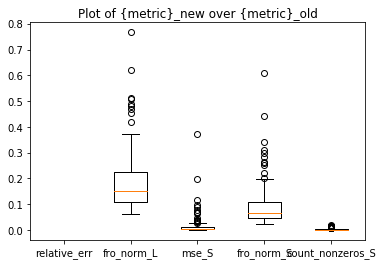

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/lib/function_base.py:4486: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


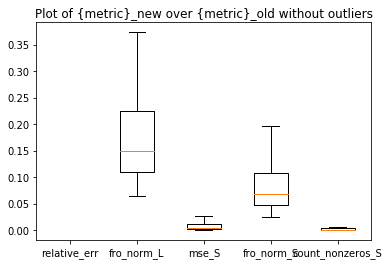

relative_err: 0/120 outliers
fro_norm_L: 9/120 outliers
mse_S: 17/120 outliers
fro_norm_S: 11/120 outliers
count_nonzeros_S: 16/120 outliers


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/lib/function_base.py:4486: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


In [69]:
relative_err = np.array([relative_err_new[i]/ relative_err_old[i] for i in range(len(relative_err_new))])
fro_norm_L = np.array([fro_norm_L_new[i]/ fro_norm_L_old[i] for i in range(len(fro_norm_L_new))])
mse_S = np.array([mse_S_new[i]/ mse_S_old[i] for i in range(len(mse_S_new))])
fro_norm_S = np.array([fro_norm_S_new[i]/ fro_norm_S_old[i] for i in range(len(fro_norm_S_new))])
count_nonzeros_S = np.array([count_nonzeros_S_new[i]/ count_nonzeros_S_old[i] for i in range(len(count_nonzeros_S_new))])
d = {"relative_err": relative_err \
    , "fro_norm_L": fro_norm_L \
    , "mse_S": mse_S \
    , "fro_norm_S": fro_norm_S \
    , "count_nonzeros_S": count_nonzeros_S
    }

fig, ax = plt.subplots()
ax.boxplot(d.values())
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_old")
plt.show()

fig, ax = plt.subplots()
ax.boxplot(d.values(), showfliers=False)
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_old without outliers")
plt.show()

for key, val in d.items():
    print(f"{key}: {count_outliers(d[key])}/{len(relative_err)} outliers")

In [70]:
print("P-values from test of mean with H1: _new/_old < 1")
# print("*Note: values are log-transformed before deriving p-values \n")
for key, val in d.items():
    print(f'{key}: ', stats.ttest_1samp(val, 1, alternative='less').pvalue)

P-values from test of mean with H1: _new/_old < 1
relative_err:  nan
fro_norm_L:  7.986415442997242e-101
mse_S:  2.2447888084899733e-165
fro_norm_S:  9.983198349852365e-124
count_nonzeros_S:  7.850184778191365e-289


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1182: RuntimeWarning: invalid value encountered in subtract
  a_zero_mean = a - mean


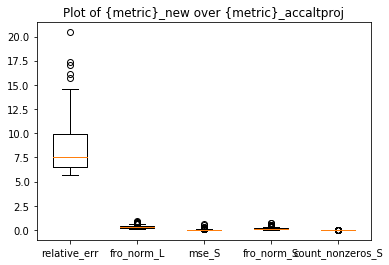

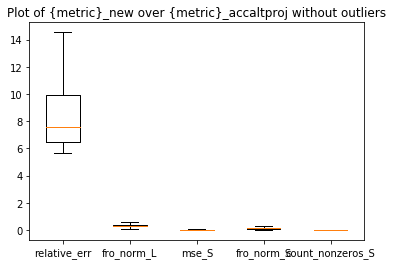

relative_err: 5/120 outliers
fro_norm_L: 9/120 outliers
mse_S: 17/120 outliers
fro_norm_S: 14/120 outliers
count_nonzeros_S: 16/120 outliers


In [71]:
relative_err = np.array([relative_err_new[i]/ relative_err_accaltproj[i] for i in range(len(relative_err_new))])
fro_norm_L = np.array([fro_norm_L_new[i]/ fro_norm_L_accaltproj[i] for i in range(len(fro_norm_L_new))])
mse_S = np.array([mse_S_new[i]/ mse_S_accaltproj[i] for i in range(len(mse_S_new))])
fro_norm_S = np.array([fro_norm_S_new[i]/ fro_norm_S_accaltproj[i] for i in range(len(fro_norm_S_new))])
count_nonzeros_S = np.array([count_nonzeros_S_new[i]/ count_nonzeros_S_accaltproj[i] for i in range(len(count_nonzeros_S_new))])
d = {"relative_err": relative_err \
    , "fro_norm_L": fro_norm_L \
    , "mse_S": mse_S \
    , "fro_norm_S": fro_norm_S \
    , "count_nonzeros_S": count_nonzeros_S
    }

fig, ax = plt.subplots()
ax.boxplot(d.values())
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_accaltproj")
plt.show()

fig, ax = plt.subplots()
ax.boxplot(d.values(), showfliers=False)
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_accaltproj without outliers")
plt.show()

for key, val in d.items():
    print(f"{key}: {count_outliers(d[key])}/{len(relative_err)} outliers")

In [72]:
print("P-values from test of mean with H1: _new/_accaltproj < 1")
#print("*Note: values are log-transformed before deriving p-values \n")
for key, val in d.items():
    print(f'{key}: ', stats.ttest_1samp(val, 1, alternative='less').pvalue)

P-values from test of mean with H1: _new/_accaltproj < 1
relative_err:  1.0
fro_norm_L:  9.37061674475159e-78
mse_S:  3.418662366674449e-127
fro_norm_S:  1.5795065914156991e-100
count_nonzeros_S:  3.9450439312527365e-269


In [ ]:
print(np.median(count_nonzeros_S_new), np.mean(count_nonzeros_S_new))
print(np.median(count_nonzeros_S_accaltproj), np.mean(count_nonzeros_S_accaltproj))